In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import jcl

In [2]:
path = "./JC283/20220910/"

In [3]:
clu_path = path + 'sorted/merged.clu'
res_path = path + 'sorted/merged.res'



In [5]:
whl_path = path + "20220910"

pos = pd.read_csv(   
                    whl_path +'.whl',
                    sep=" ",
                    header=None,
                    names=["x1","y1","x2","y2","timestamps","valid"]
)



pos["x1"],pos["y1"] = jcl.utils.interpolate_position(pos["x1"], pos["y1"], unknown_val=1023)

# x1 = pos[pos['x1'] != 1023].x1
# y1 = pos[pos['x1'] != 1023].y1

# plt.plot(x1,y1)

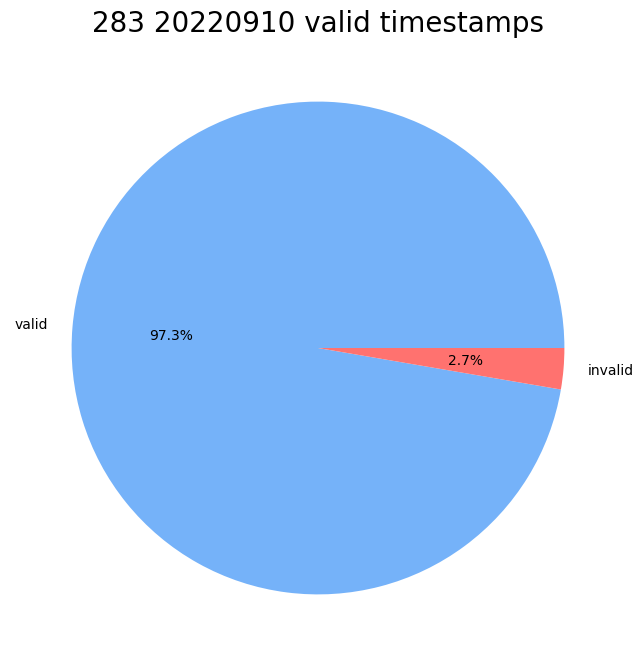

In [6]:
valid = pos["valid"]
# I'll make a humble pie chart because I can't think of how to conserve the time data. Possibly with a matrix.
fig, ax = plt.subplots(figsize=(8,8))
labels = ['valid', 'invalid']
ax.pie([valid.mean(), 1-valid.mean()],
       labels=labels,
       autopct='%1.1f%%', #formatting
       colors=['#75b2f9', '#ff726f'],
      )
ax.set_title("283 20220910"+" valid timestamps", fontsize=20)
plt.show()

In [7]:
session_shifts_path = path + 'session_shifts.txt' 

session_shifts = np.array(np.loadtxt(session_shifts_path), dtype=int)

session_shifts

# 1: Sleep 1                 86400147
# 2-4: Training 1            231570138

# 5: Sleep 2                  294284235
# 6: Training 2               365943882            
# 7: Sleep 3

array([ 86400147, 172800294, 216000441, 231570138, 294284235, 365943882,
       446150829])

In [8]:
filtered_pos = pos[( pos['timestamps'] > 86400147) & (pos['timestamps'] <= 365943882 )].copy().reset_index()

filtered_pos.loc[(filtered_pos['timestamps'] > 231570138) & (filtered_pos['timestamps'] <= 294284235), ['x1', 'y1']] = 0
# filtered_pos.loc[(filtered_pos['timestamps'] > 231570138) & (filtered_pos['timestamps'] <= 294284235)] = 0

filtered_pos

,index,x1,y1,x2,y2,timestamps,valid
0,180003,106.0,94.0,1023,1023,86400620,1
1,180004,106.0,94.0,1023,1023,86401100,1
2,180005,105.0,94.0,1023,1023,86401580,1
3,180006,106.0,94.0,1023,1023,86402060,1
4,180007,106.0,94.0,1023,1023,86402540,1
...,...,...,...,...,...,...,...
582383,762386,135.0,101.0,1023,1023,365942298,1
582384,762387,135.0,101.0,1023,1023,365942778,1
582385,762388,135.0,101.0,1023,1023,365943019,1
582386,762389,73.0,79.0,1023,1023,365943262,1


In [45]:
spike_times = jcl.load.spike_times_from_res_and_clu(res_path, clu_path, exclude_clusters=[0, 1], ts_limits=(filtered_pos.at[0,'timestamps'], filtered_pos.at[len(filtered_pos)-1,'timestamps']))
last = 0
first = 99999999999
for i in range(len(spike_times)):
    subarray = np.array(spike_times[i] , dtype = np.int64)
    spike_times[i] = subarray[ (subarray < 231570138 ) | (subarray >= 294284235 ) ].tolist()
    if max(subarray) > last:
        last = max(subarray)
    if min(subarray) < first:
        first = min(subarray)
        
binned_data, bin_edges, bin_num = bins_from_spike_times( 
                            spike_times, 
                            (filtered_pos.at[0,'timestamps'], filtered_pos.at[len(filtered_pos)-1,'timestamps'])   
)

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


#####CAN USE BIN EDGES INSTEAD OF BIN CENTERS IN THIS AND THEN YOU NEED TO SKIP THE LAST POSITION I THINK


x1 = np.interp(bin_centers, filtered_pos['timestamps'], filtered_pos['x1'])
y1 = np.interp(bin_centers, filtered_pos['timestamps'], filtered_pos['y1'])

# x1 = np.round(x1).astype(np.int64)
# y1 = np.round(y1).astype(np.int64)
position = np.column_stack((x1, y1))

(582383,) (162, 582382)


In [46]:
def speed_filter(positions, bin_len, speed_thr):
    """ Filter positions based on speed.
        Return both parts where speed > speed_thr and where speed <= speed_thr.

            positions - array of positions of shape (n,1) or (n,2)
            bin_len - duration of temporal bins in ms
            speed_thr - threshold for speed
        Return:
            (high_speed_positions, low_speed_positions)
    """
    assert speed_thr is not None
    speed = np.array(jcl.utils.calc_speed(positions, bin_len))
    speed_h_idx = speed >= speed_thr
    speed_l_idx = speed < speed_thr
    positions[speed_l_idx] = [0,0]
    return positions, speed_l_idx

speed_filtered_positions, low_speed_index = speed_filter(position, 20, 5)
speed_filtered_positions


array([[106.        ,  94.        ],
       [105.5       ,  94.        ],
       [  0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ],
       [ 73.51028807,  79.18106996],
       [ 73.99583333,  79.        ]])

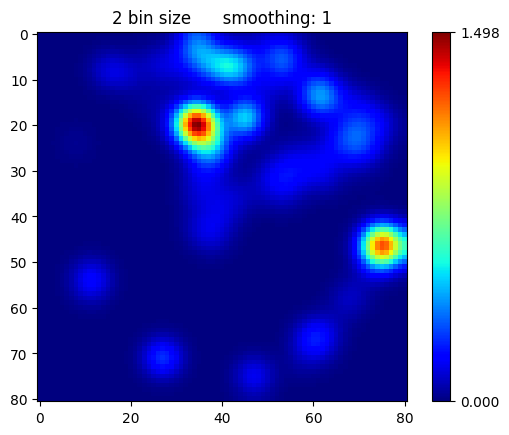

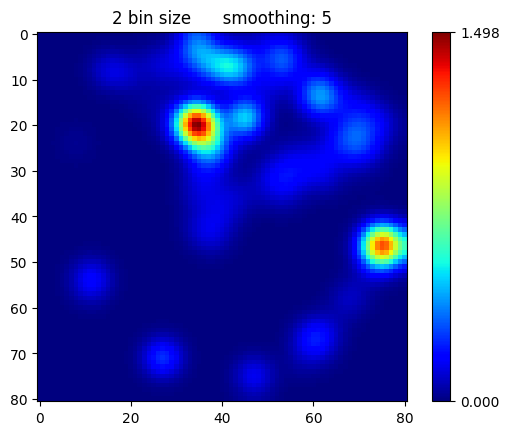

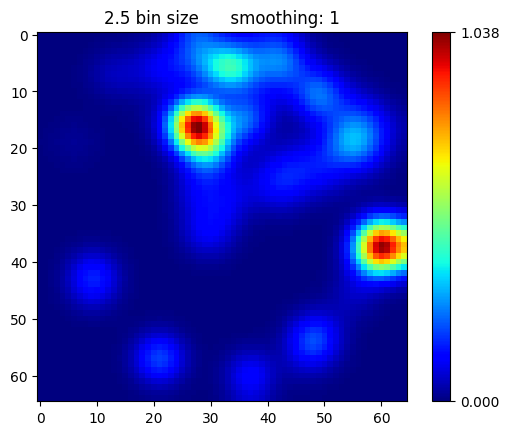

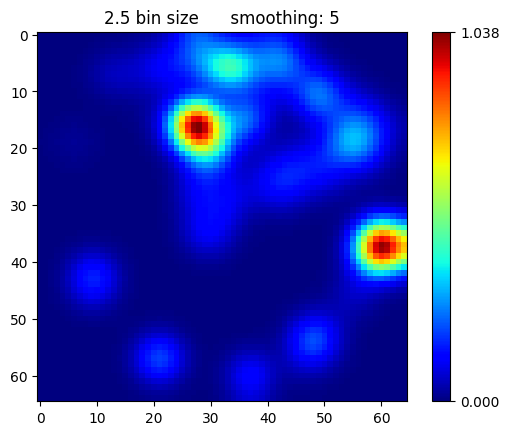

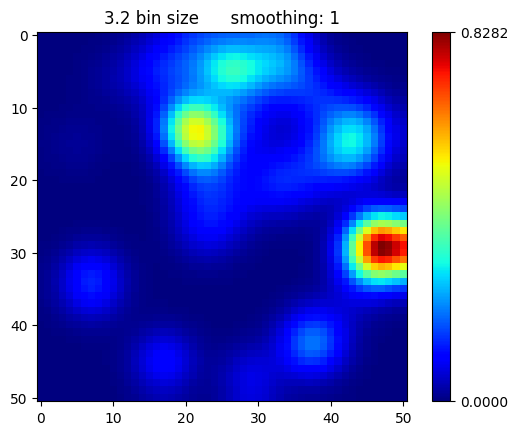

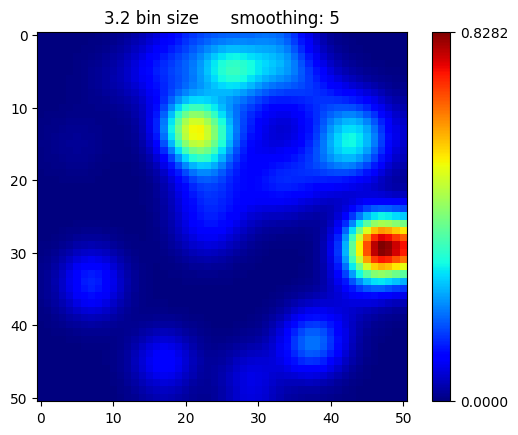

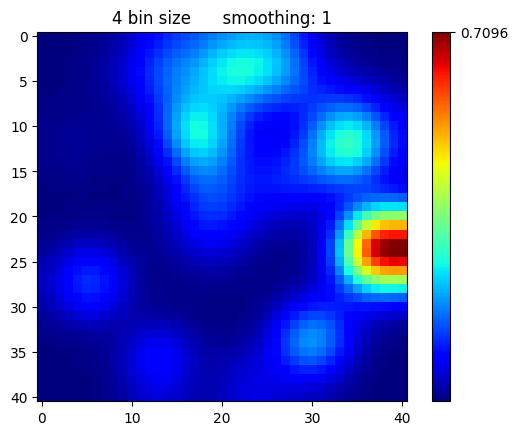

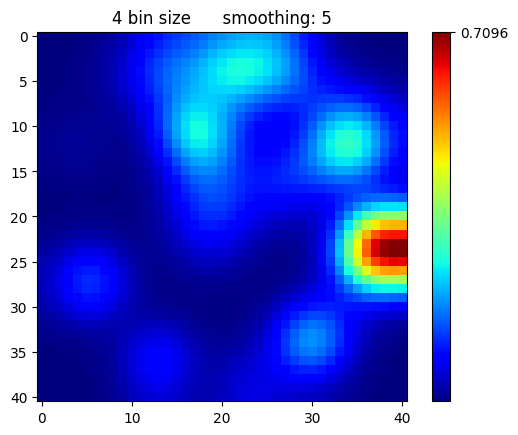

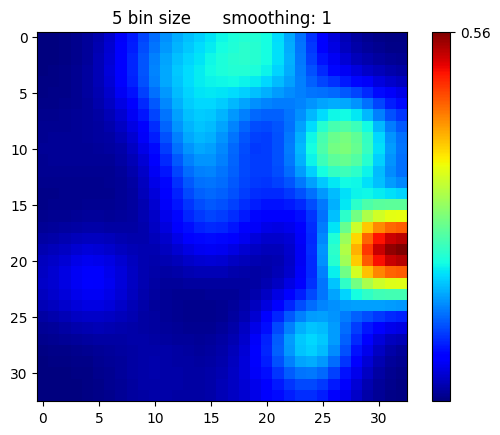

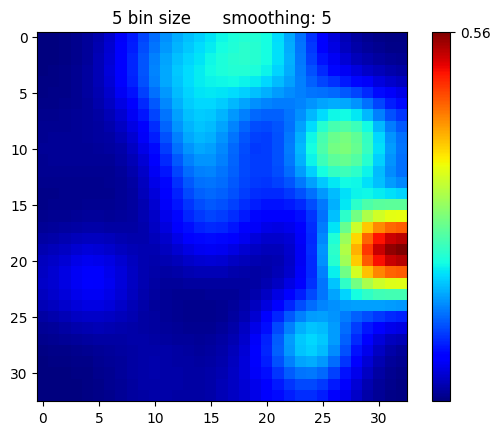

In [56]:
for i in range(1,2):    
    binned_data[i, :][low_speed_index] = 0 ## dont want to include spikes that happened when the animal was not moving
    
    bin_sizes = [2, 2.5, 3.2, 4, 5]
    smoothing = [ 1, 5]
    
    for bin_size in bin_sizes:
        for sd in smoothing:
    
            placemap = jcl.analysis.FiringRateMap(
                                                    binned_data[i, :],
                                                    speed_filtered_positions, 
                                                    np.array([160,160]), 
                                                    np.array([bin_size,bin_size]), 
                                                    20,
                                                    smooth_sd = sd
            )
            jcl.visualization.plot_map(placemap, title = str(bin_size) +" bin size      smoothing: "+str(sd))

582382 582382


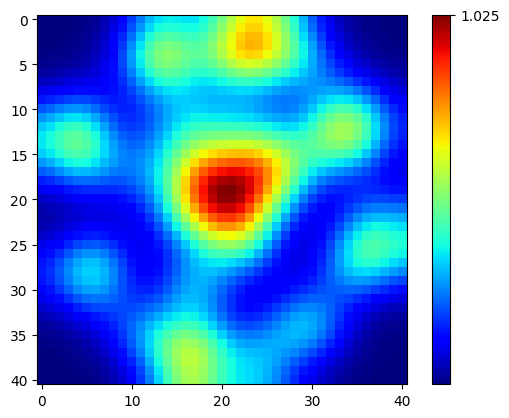

582382 582382


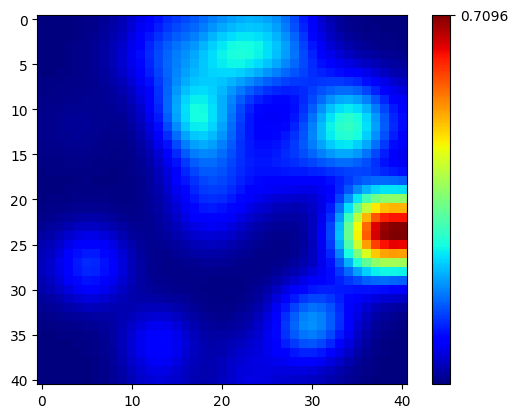

582382 582382


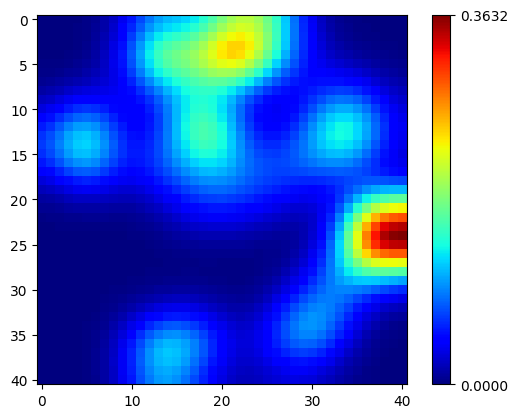

582382 582382


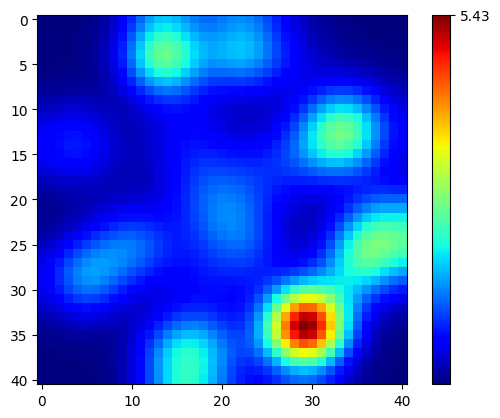

582382 582382


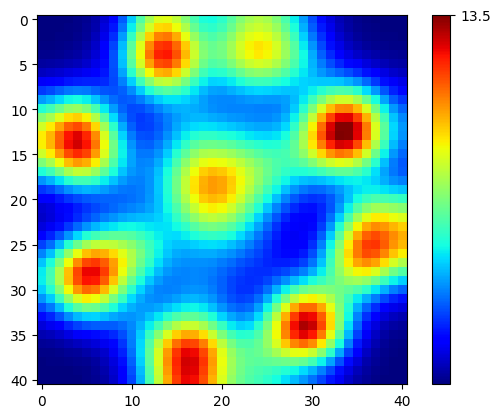

582382 582382


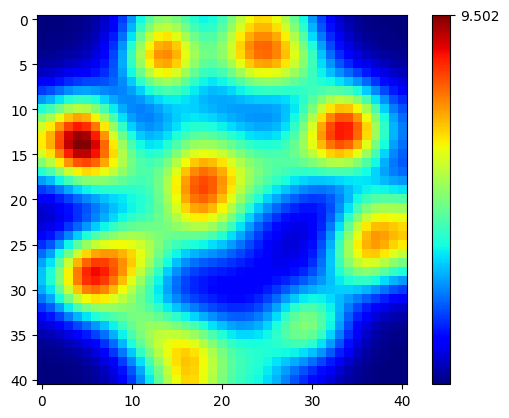

582382 582382


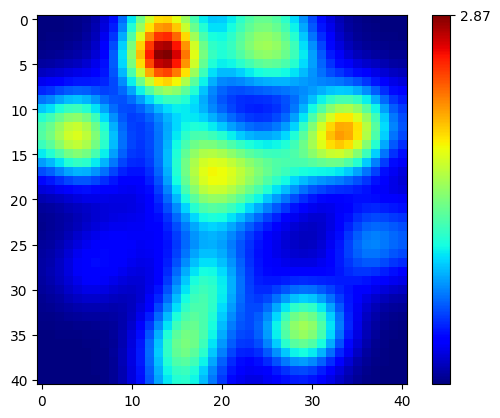

582382 582382


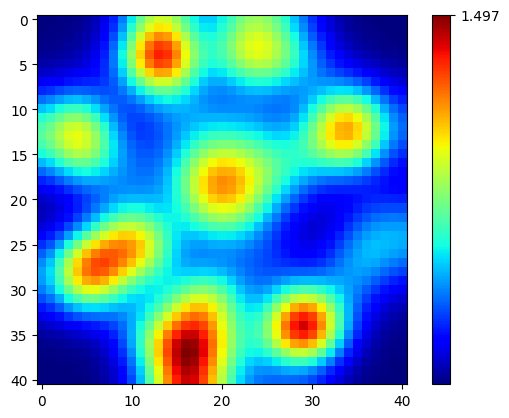

582382 582382


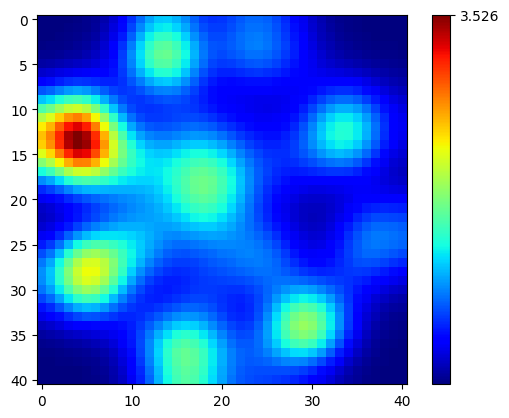

582382 582382


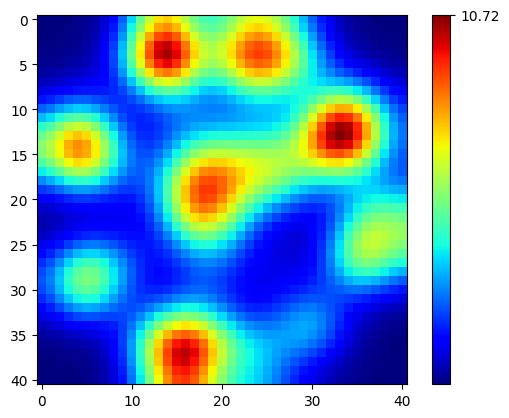

582382 582382


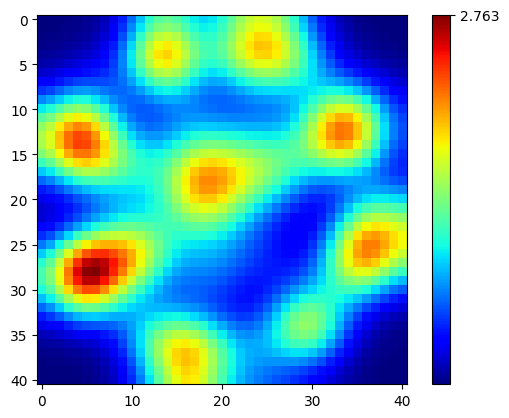

582382 582382


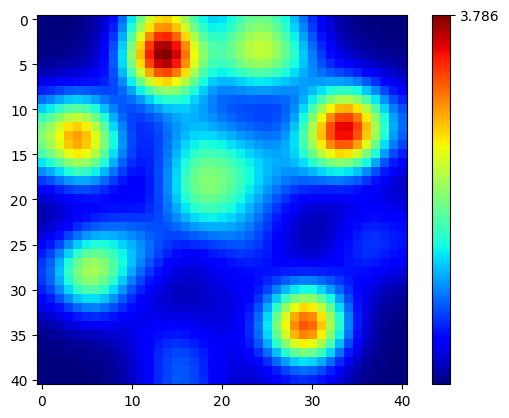

582382 582382


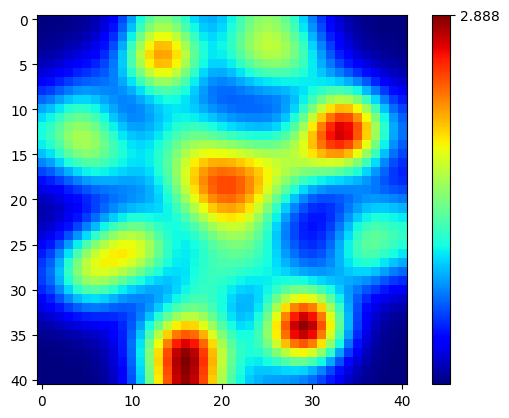

582382 582382


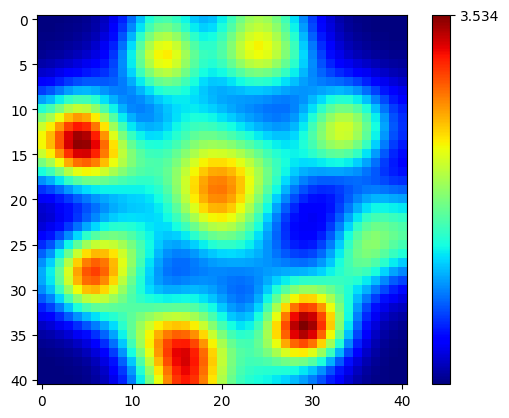

582382 582382


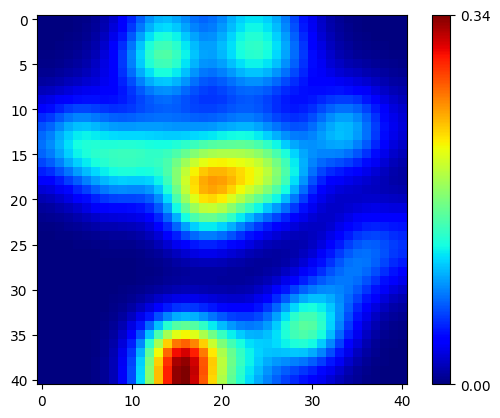

582382 582382


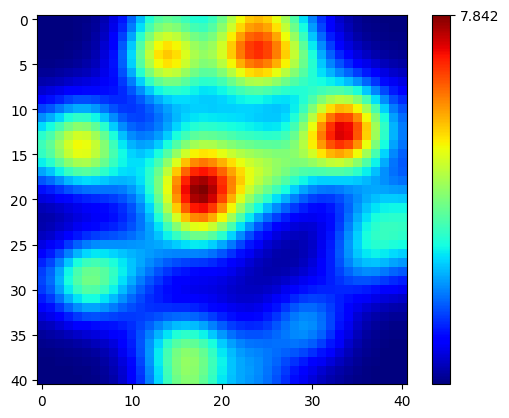

582382 582382


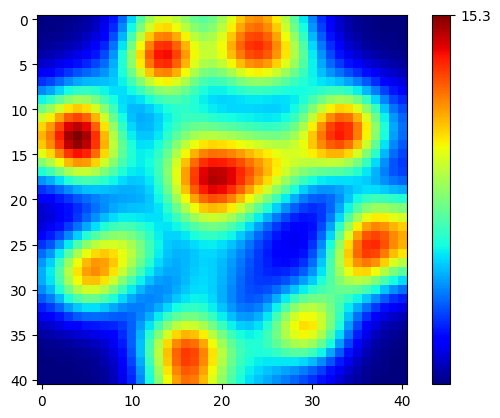

582382 582382


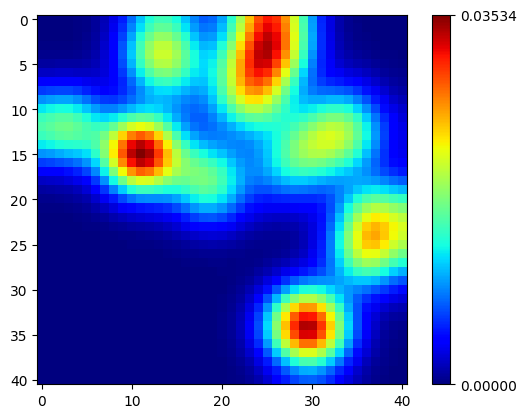

582382 582382


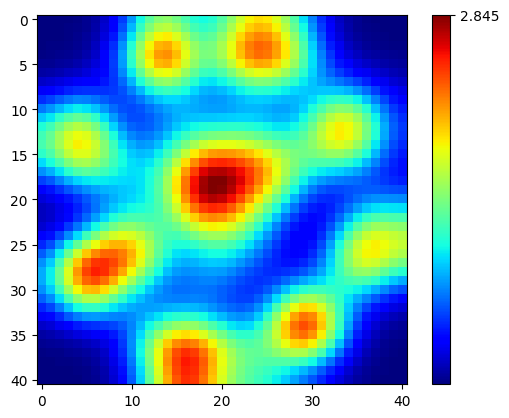

582382 582382


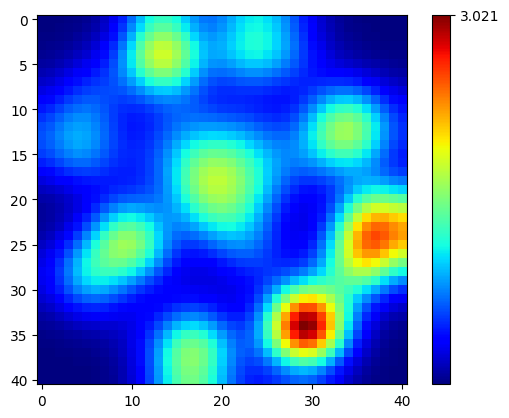

582382 582382


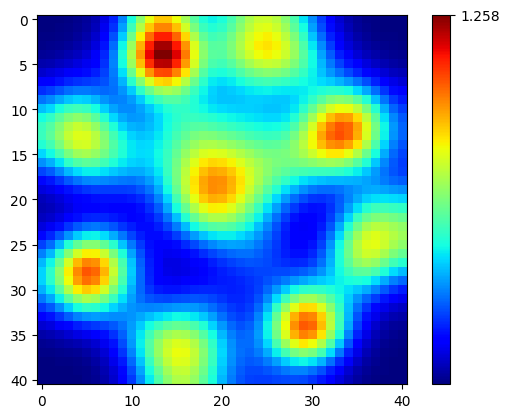

582382 582382


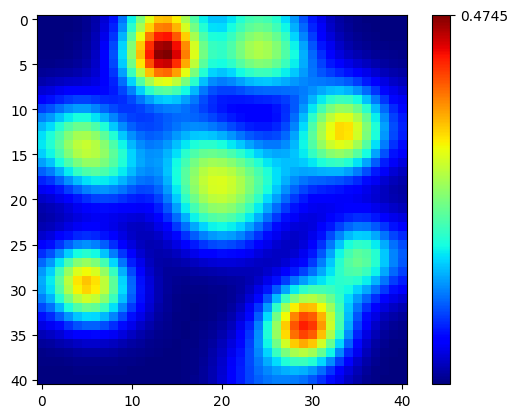

582382 582382


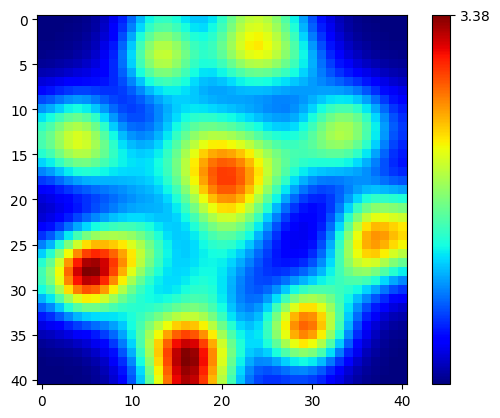

582382 582382


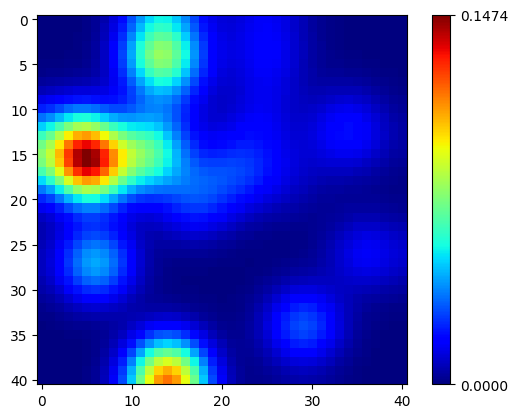

582382 582382


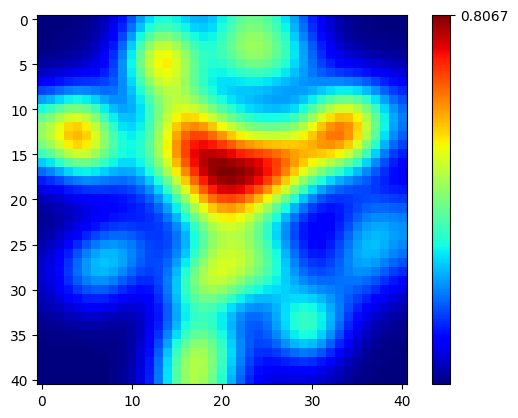

582382 582382


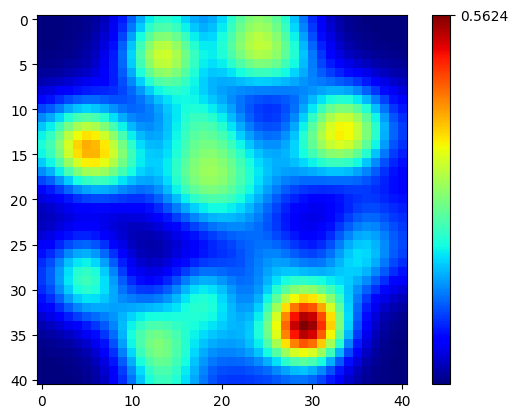

582382 582382


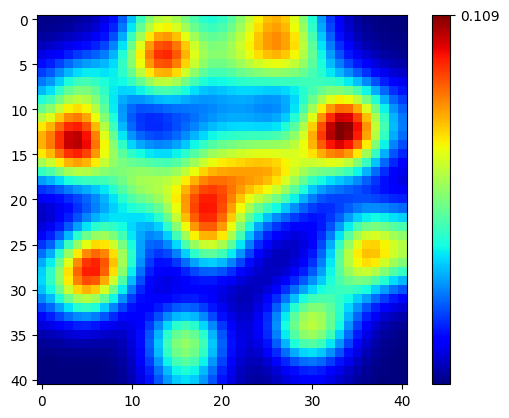

582382 582382


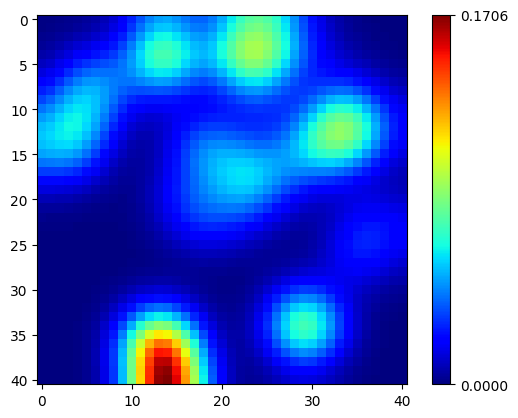

582382 582382


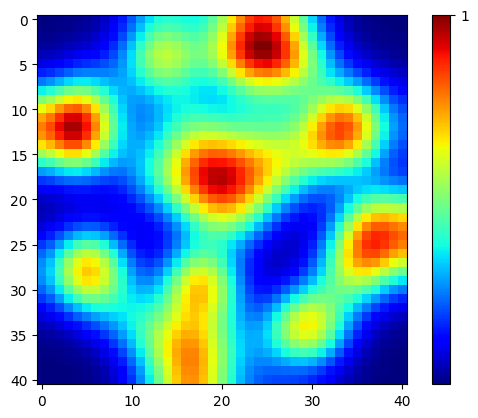

582382 582382


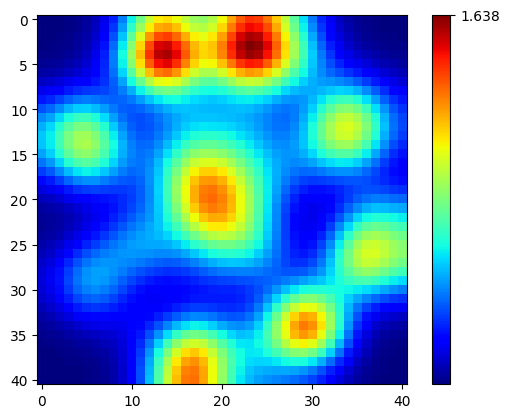

582382 582382


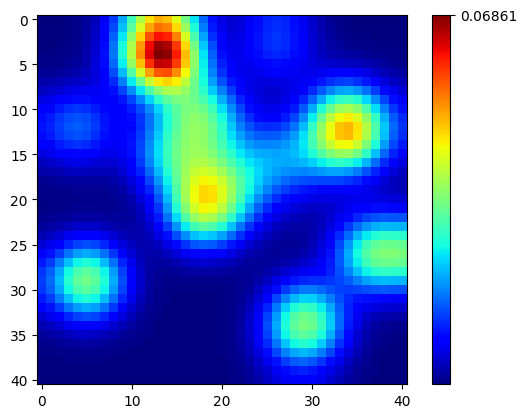

582382 582382


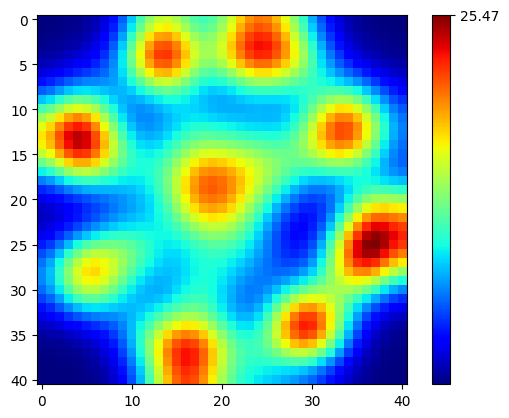

582382 582382


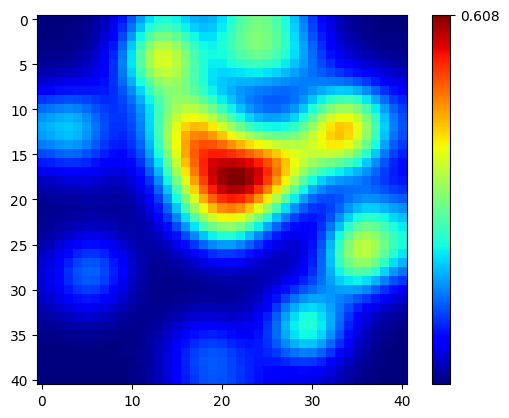

582382 582382


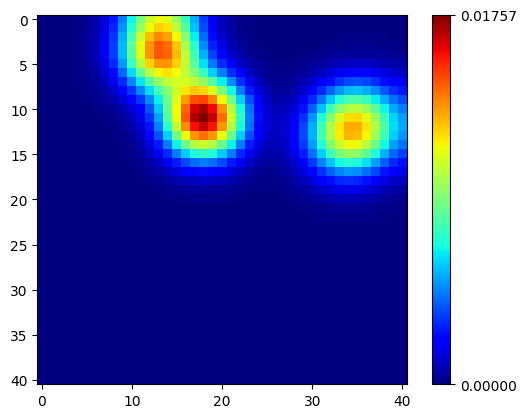

582382 582382


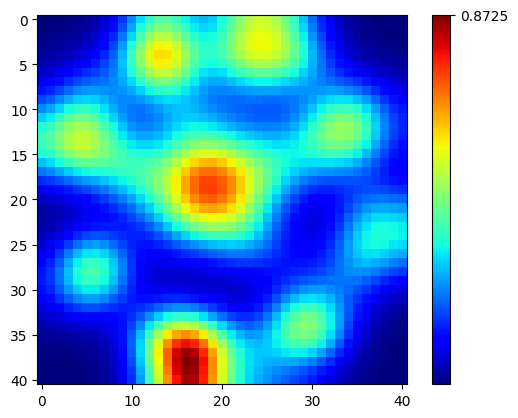

582382 582382


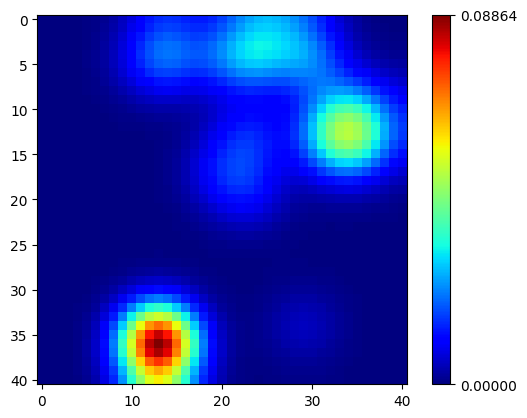

582382 582382


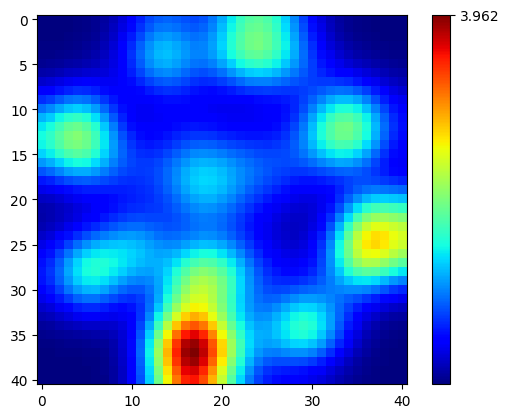

582382 582382


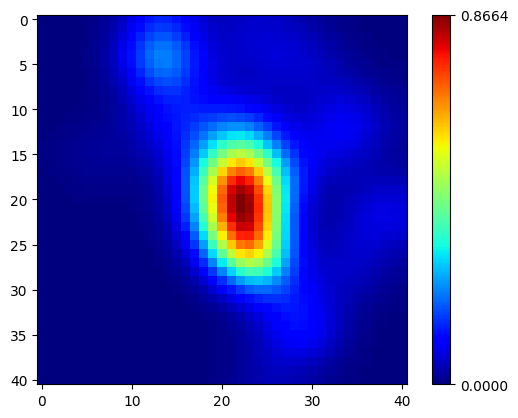

582382 582382


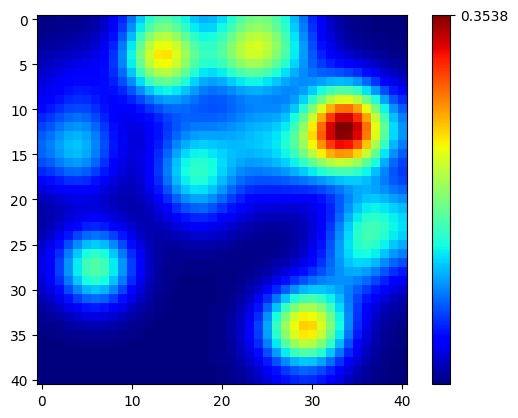

582382 582382


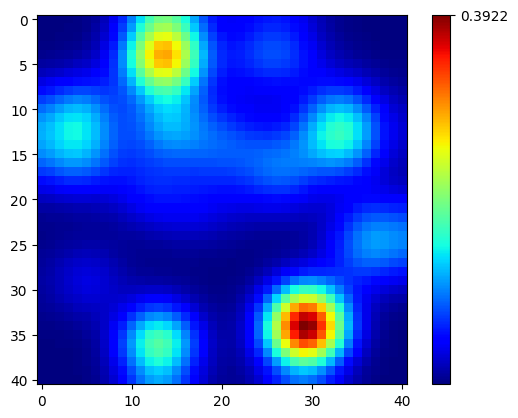

582382 582382


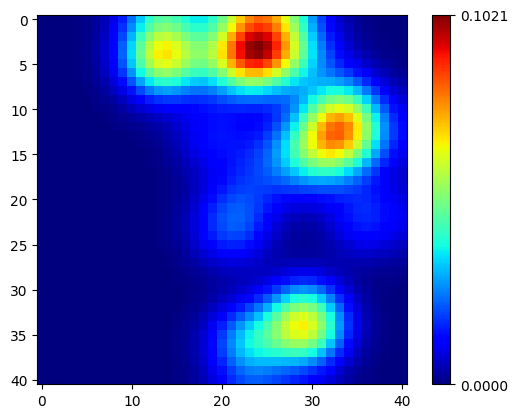

582382 582382


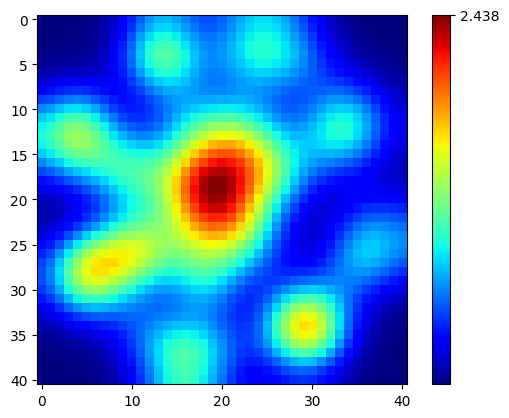

582382 582382


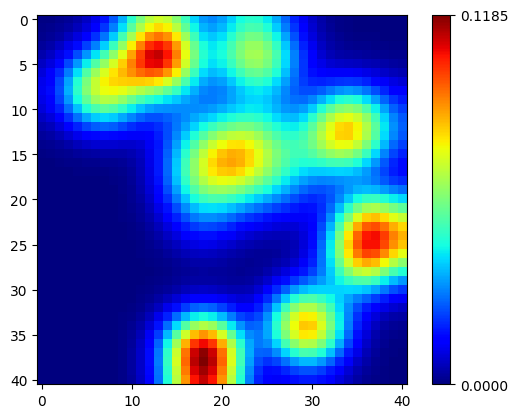

582382 582382


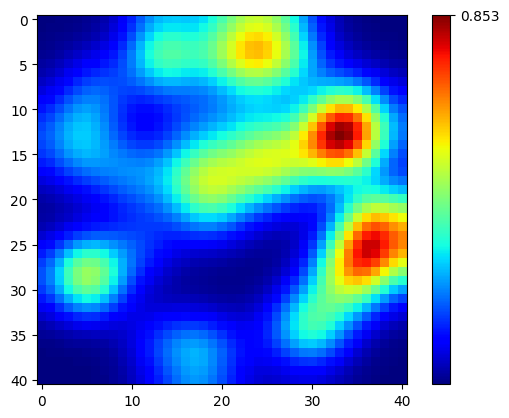

582382 582382


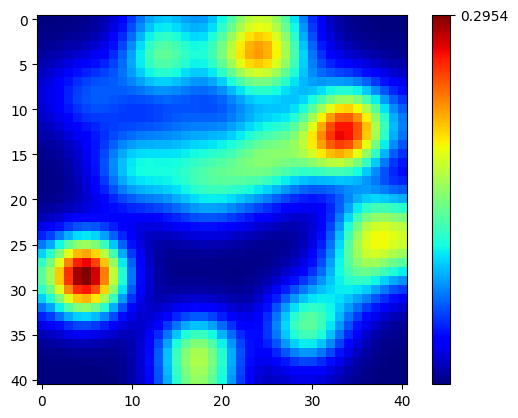

582382 582382


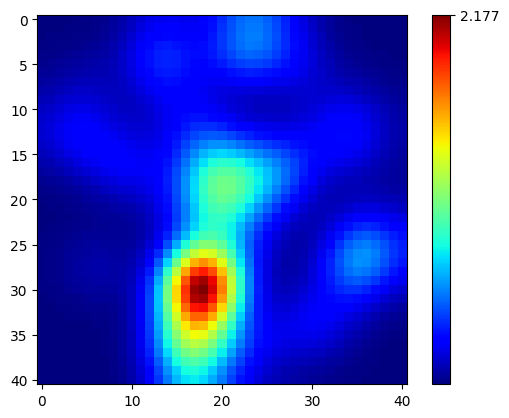

582382 582382


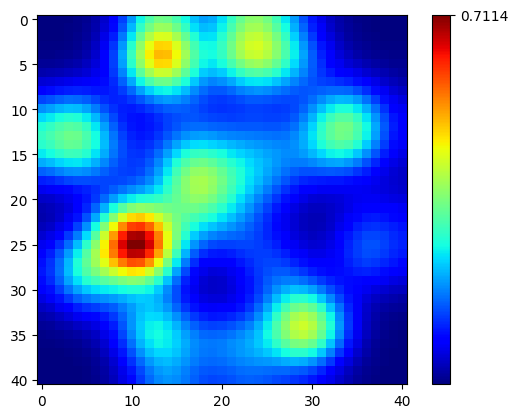

582382 582382


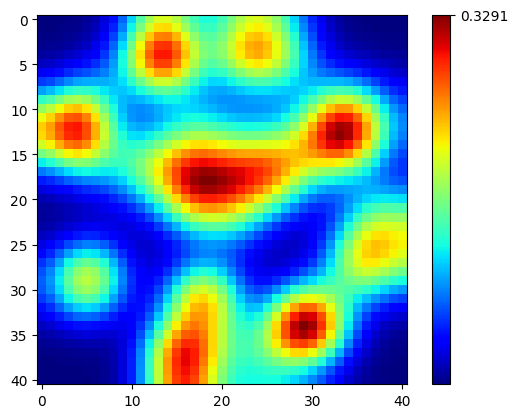

582382 582382


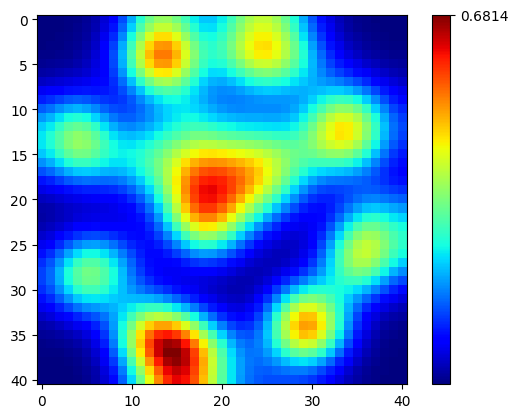

582382 582382


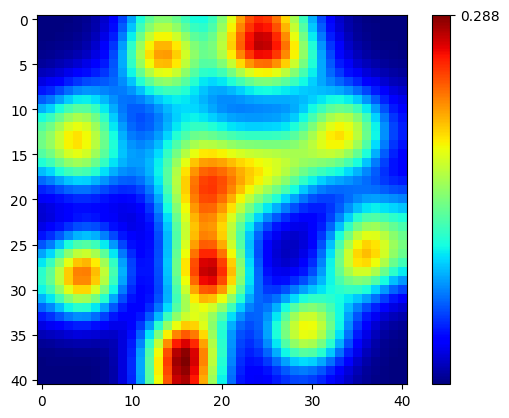

582382 582382


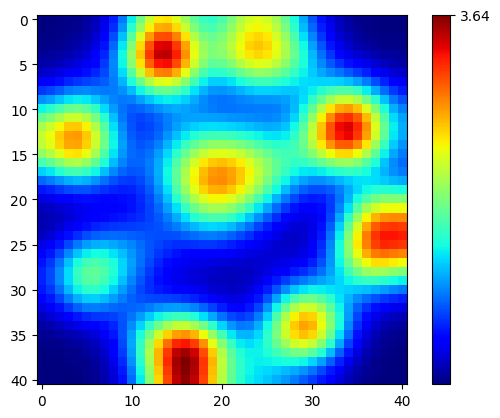

582382 582382


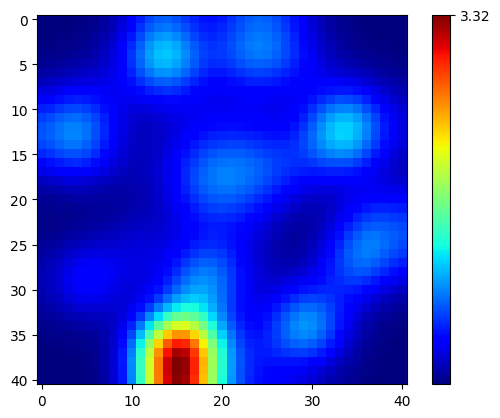

582382 582382


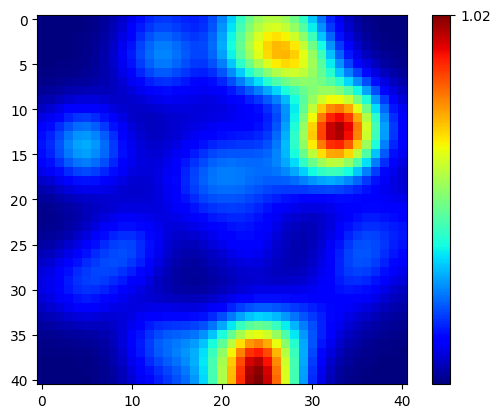

582382 582382


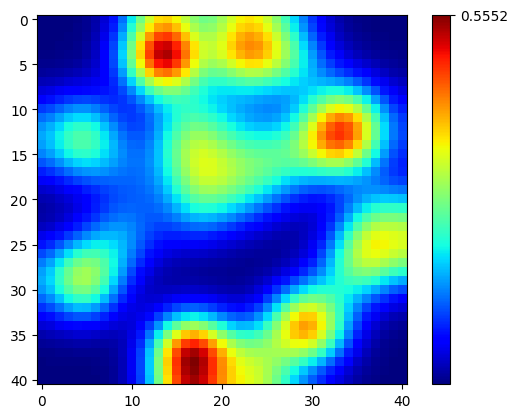

582382 582382


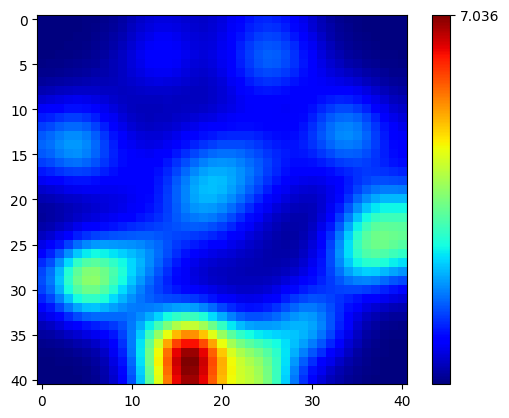

582382 582382


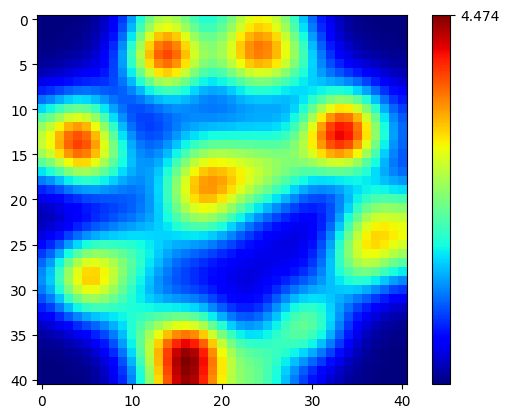

582382 582382


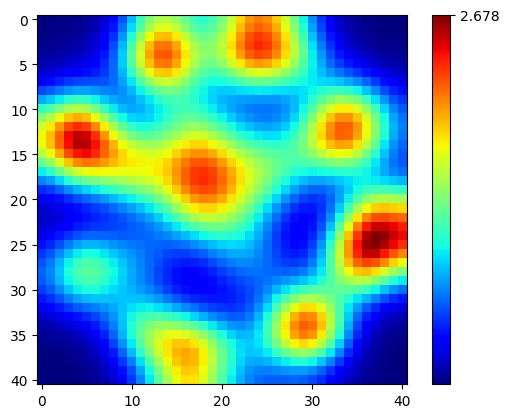

582382 582382


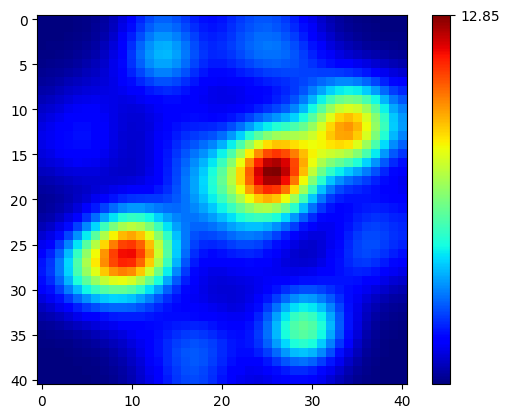

582382 582382


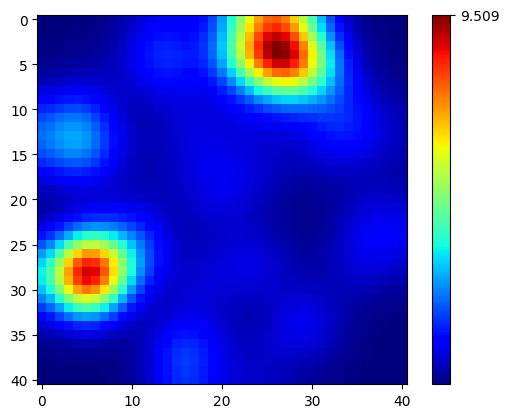

582382 582382


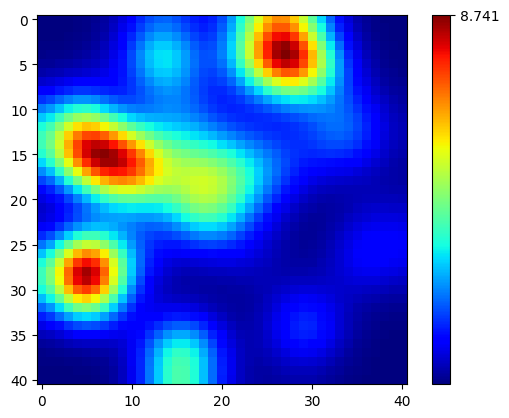

582382 582382


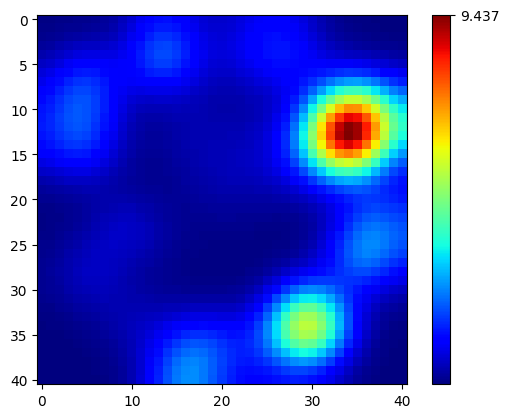

582382 582382


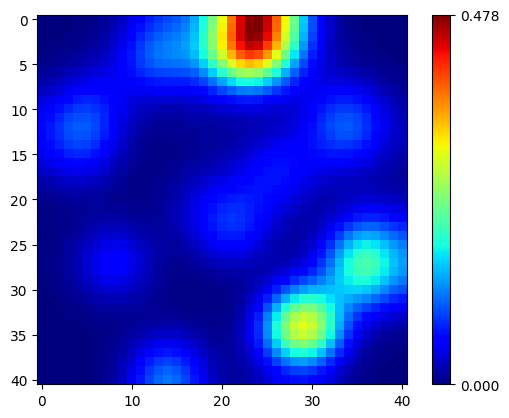

582382 582382


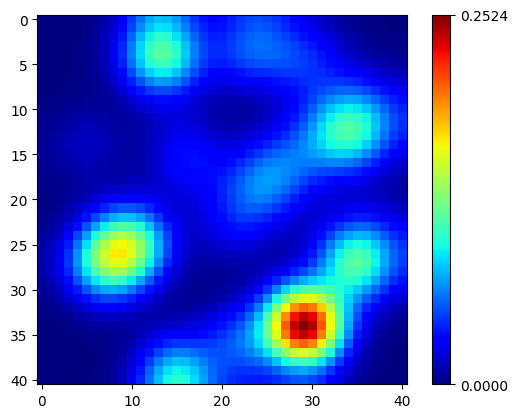

582382 582382


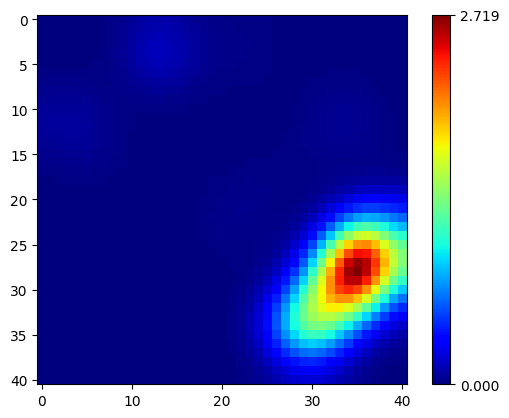

582382 582382


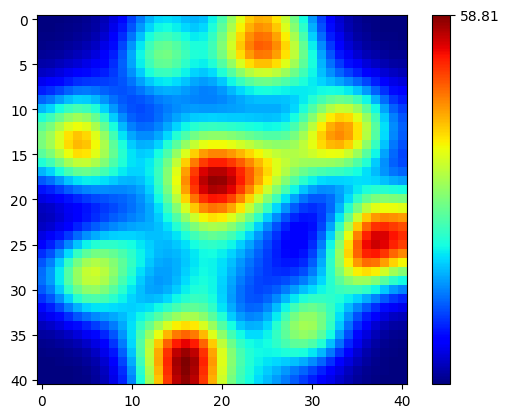

582382 582382


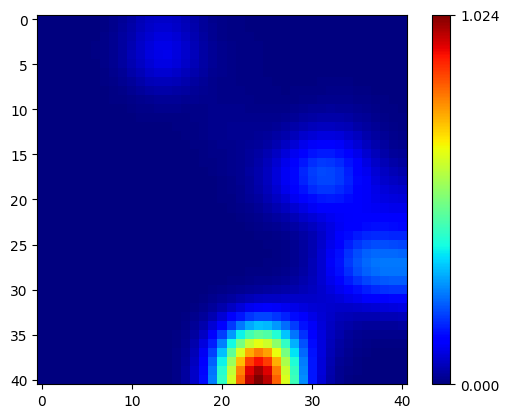

582382 582382


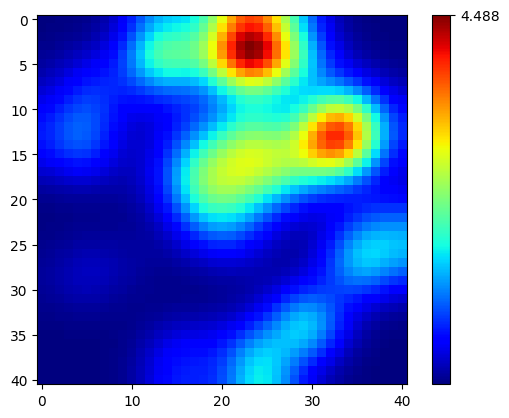

582382 582382


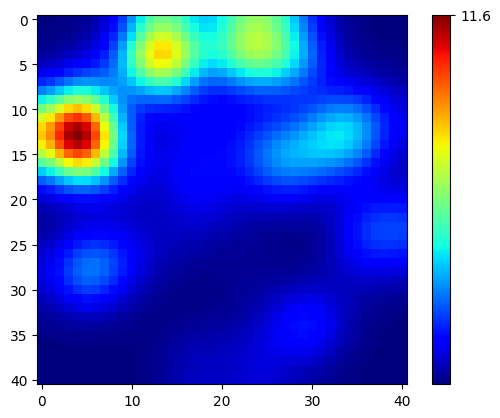

582382 582382


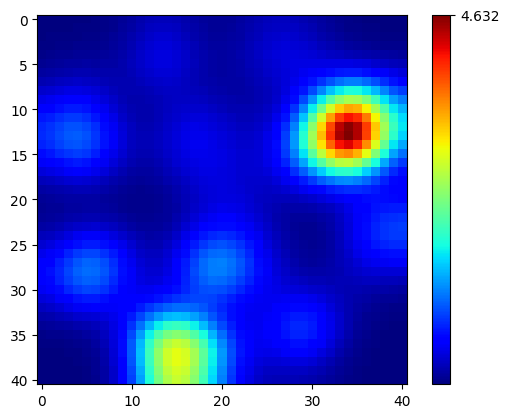

582382 582382


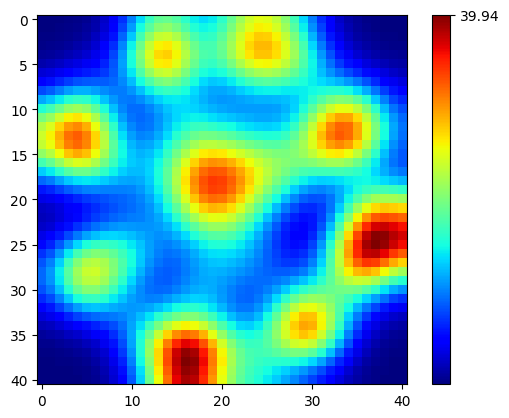

582382 582382


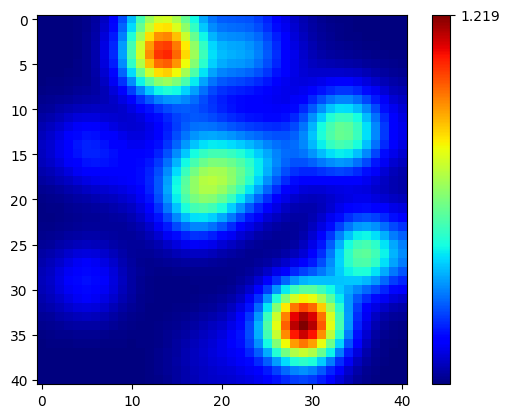

582382 582382


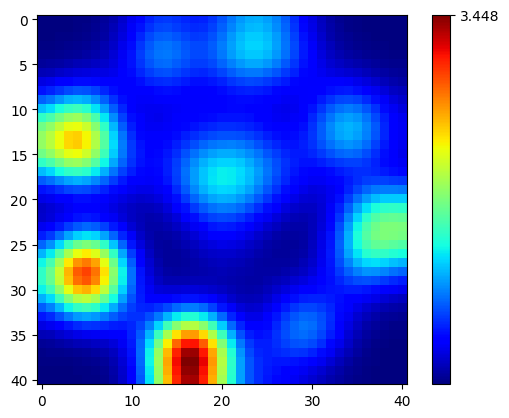

582382 582382


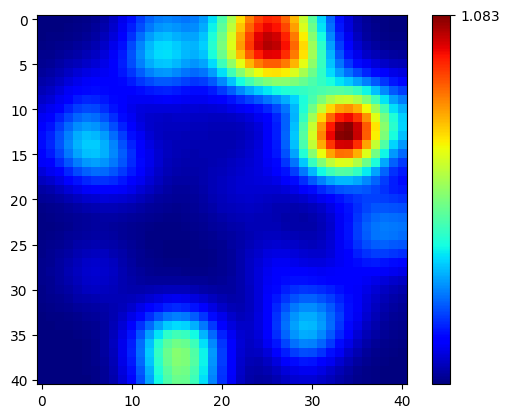

582382 582382


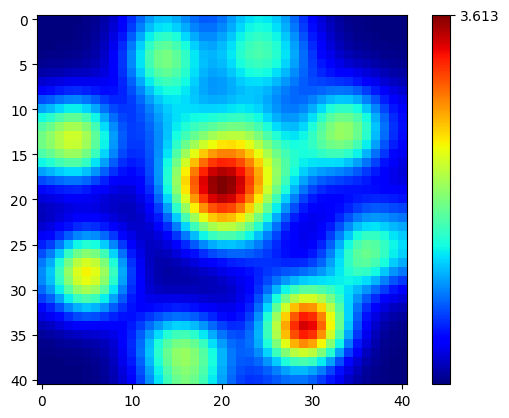

582382 582382


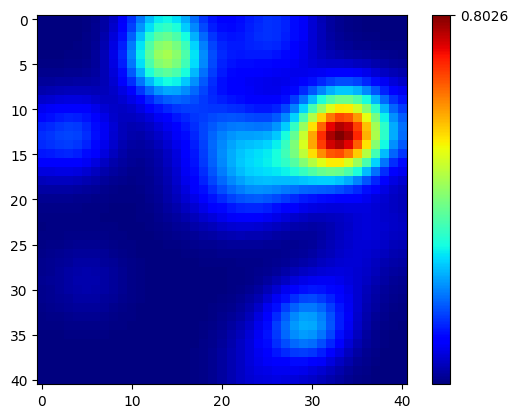

582382 582382


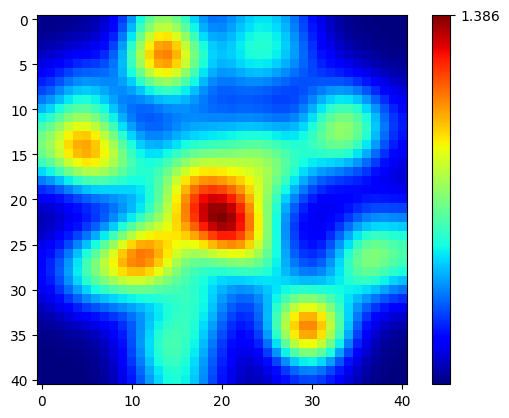

582382 582382


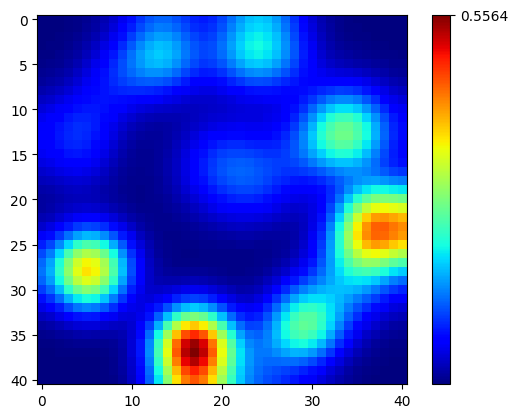

582382 582382


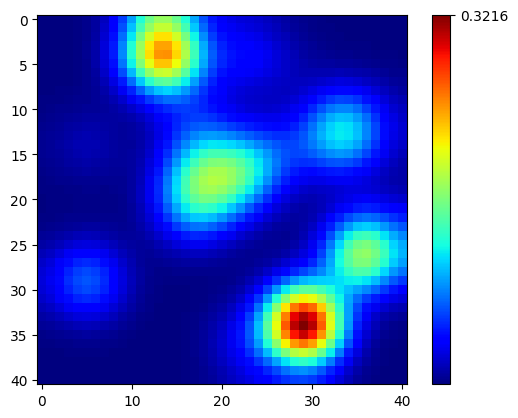

582382 582382


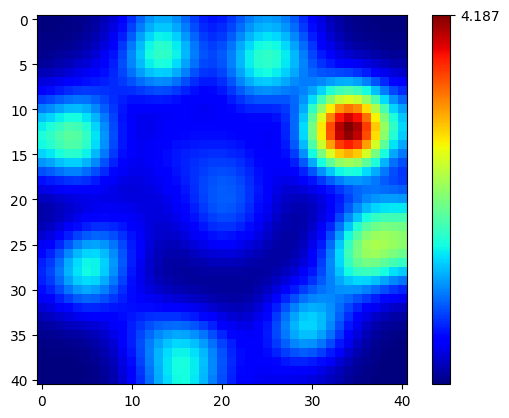

582382 582382


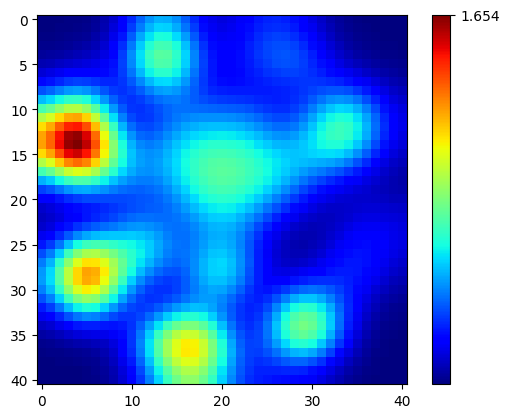

582382 582382


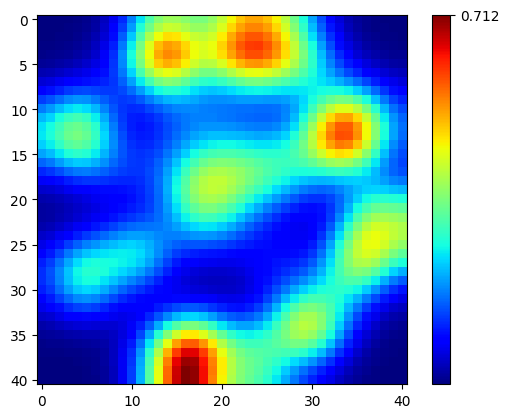

582382 582382


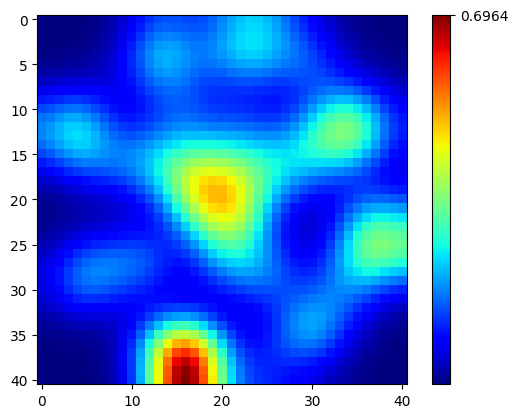

582382 582382


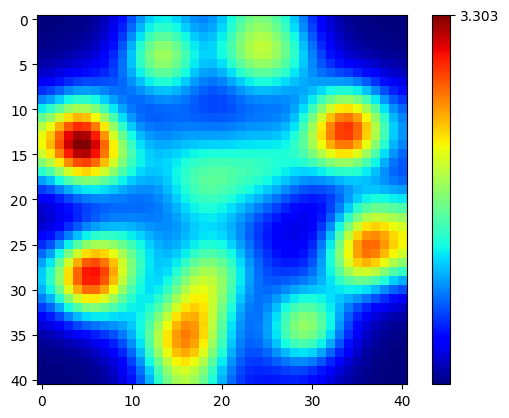

582382 582382


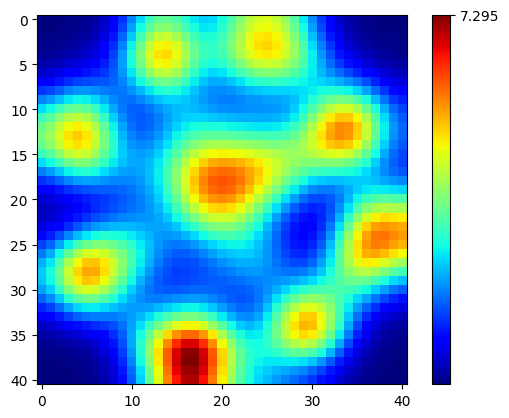

582382 582382


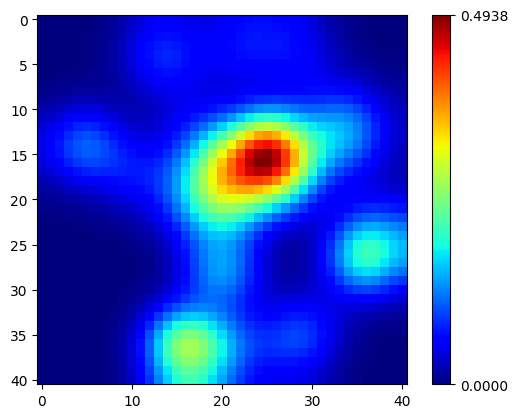

582382 582382


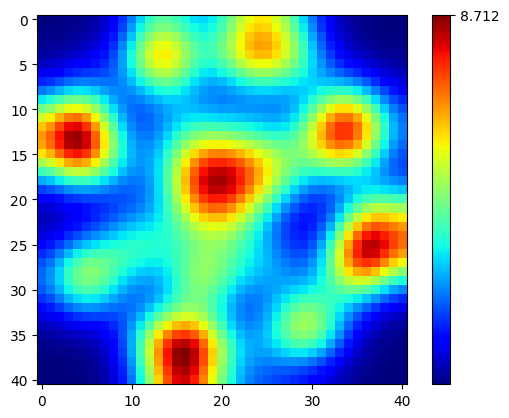

582382 582382


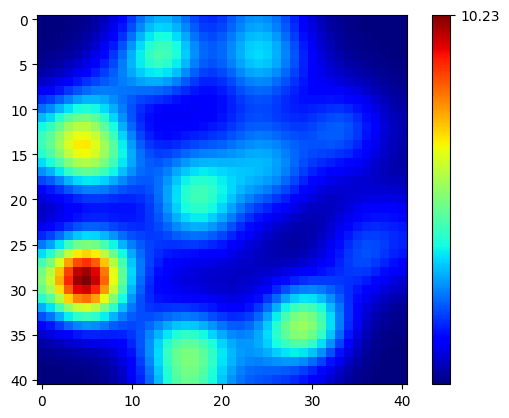

582382 582382


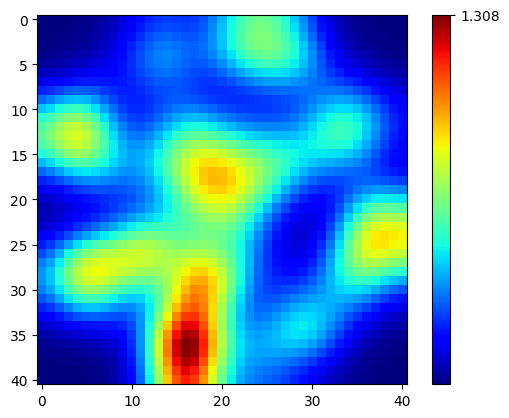

582382 582382


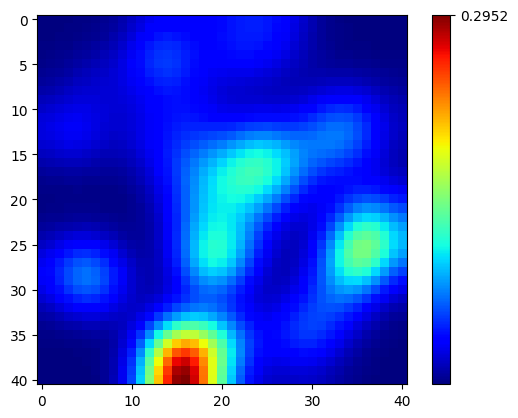

582382 582382


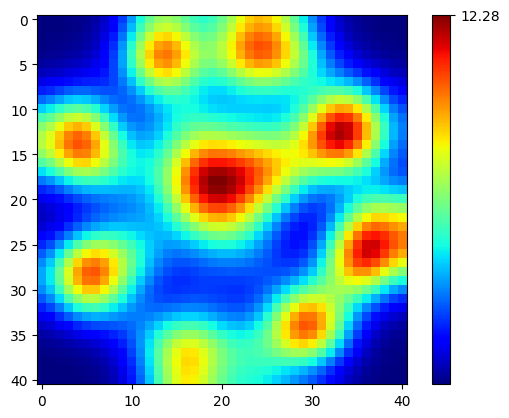

582382 582382


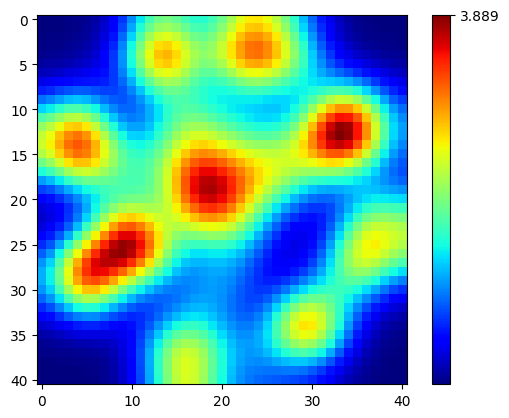

582382 582382


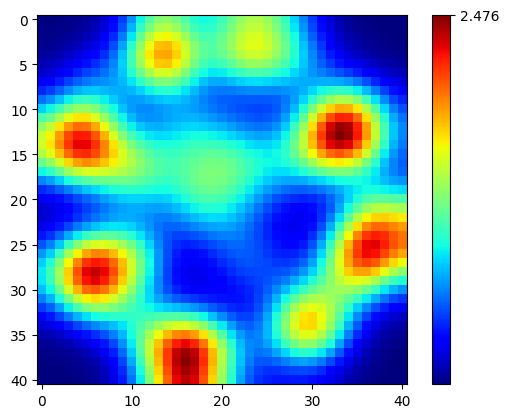

582382 582382


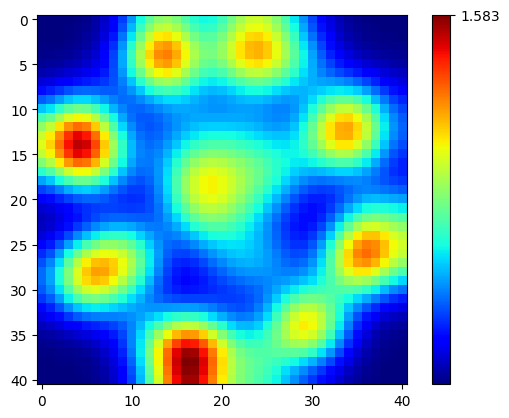

582382 582382


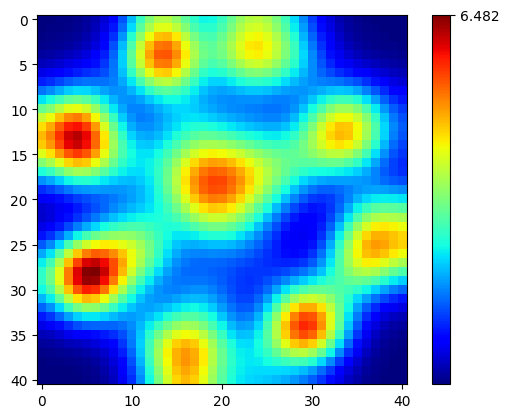

582382 582382


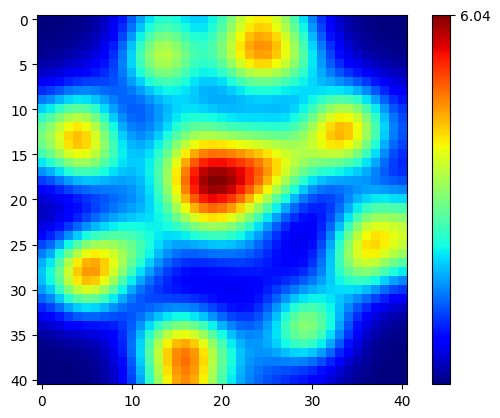

582382 582382


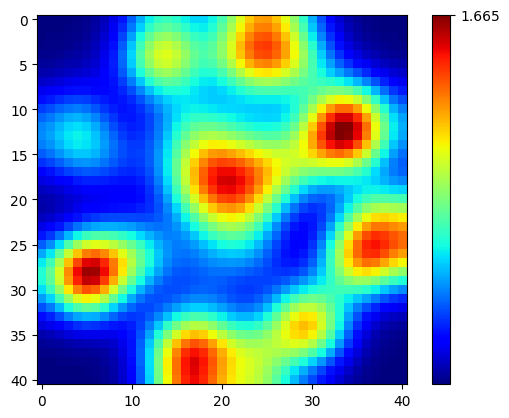

582382 582382


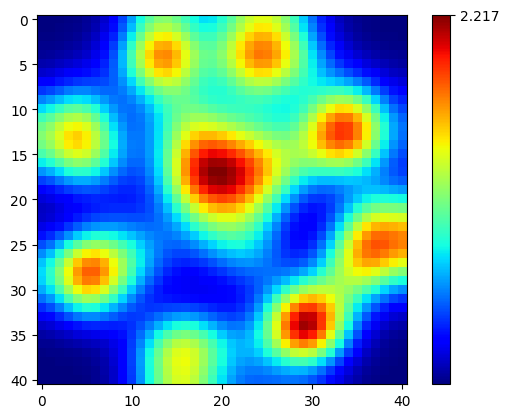

582382 582382


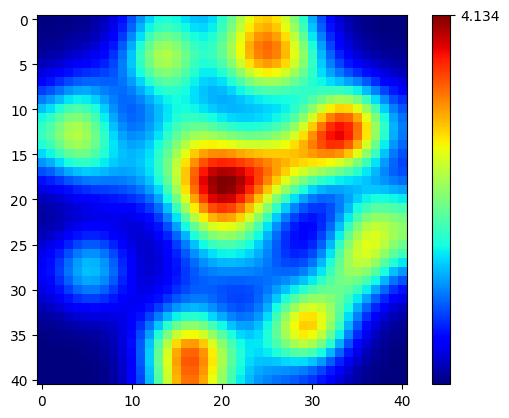

582382 582382


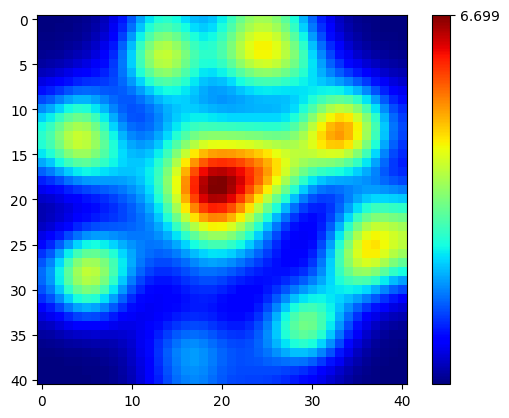

582382 582382


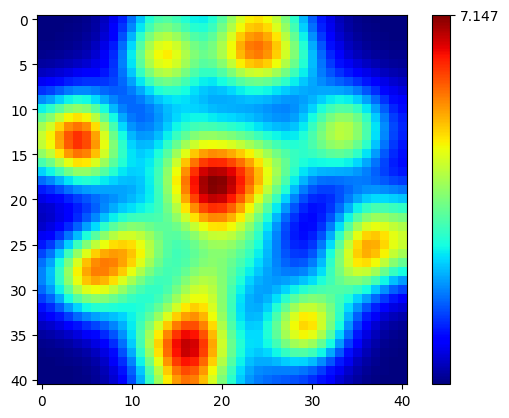

582382 582382


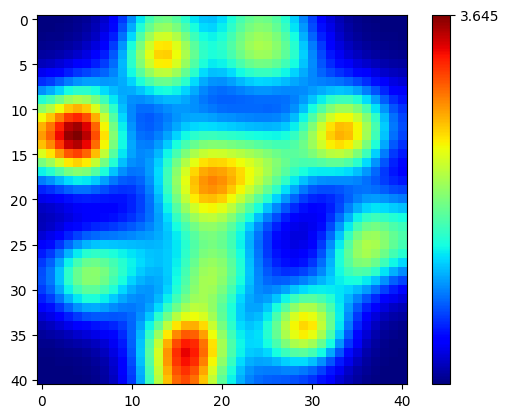

582382 582382


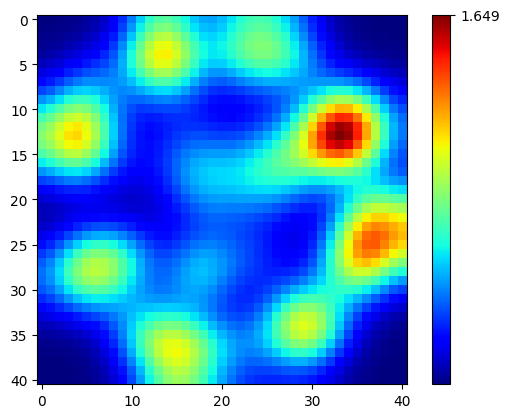

582382 582382


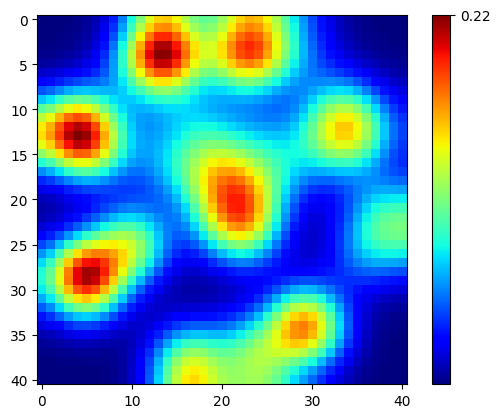

582382 582382


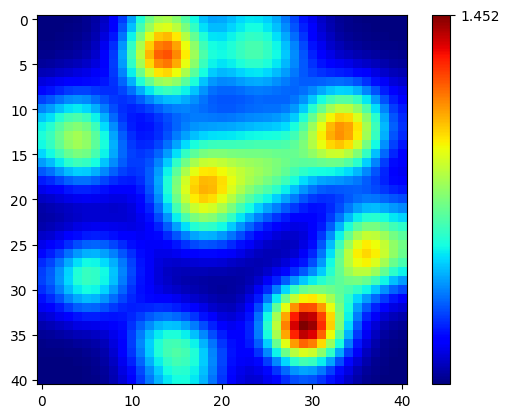

582382 582382


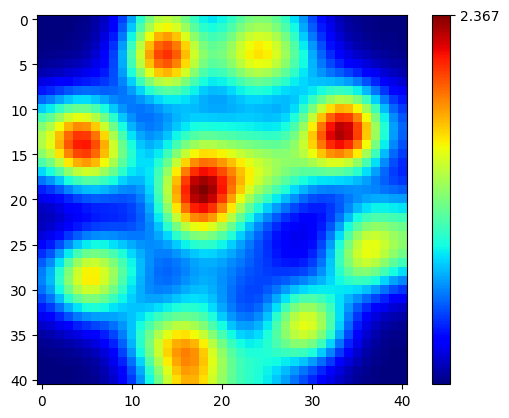

582382 582382


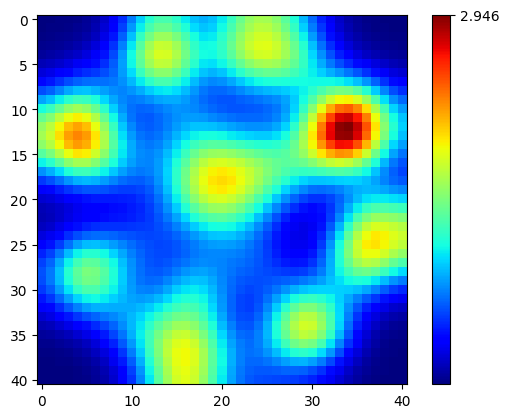

582382 582382


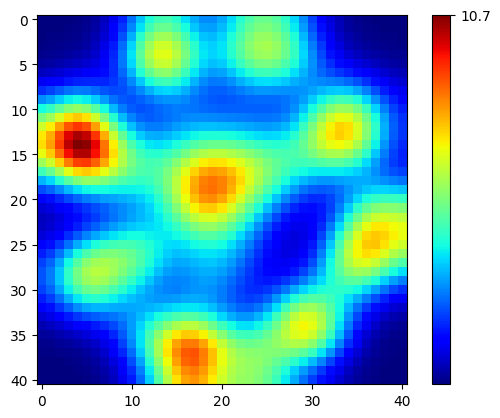

582382 582382


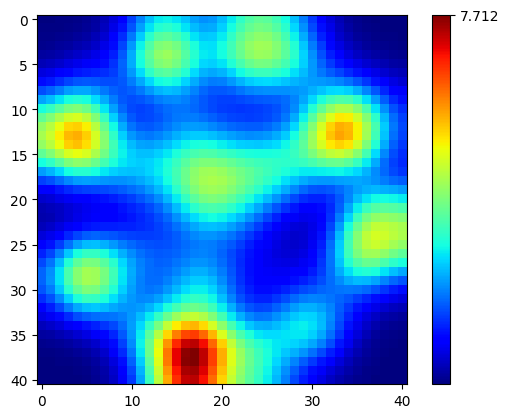

582382 582382


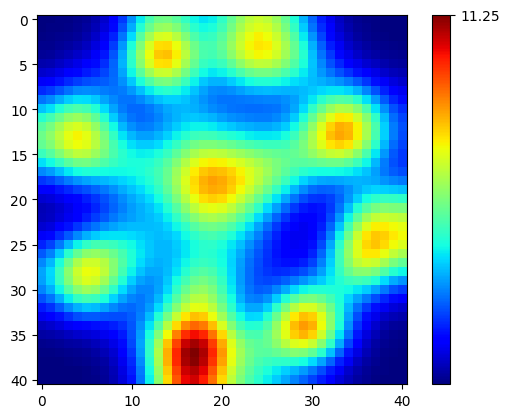

582382 582382


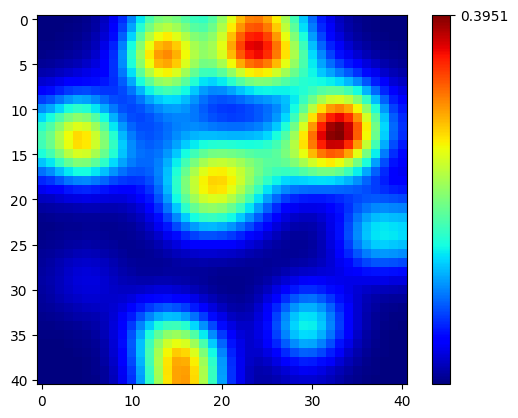

582382 582382


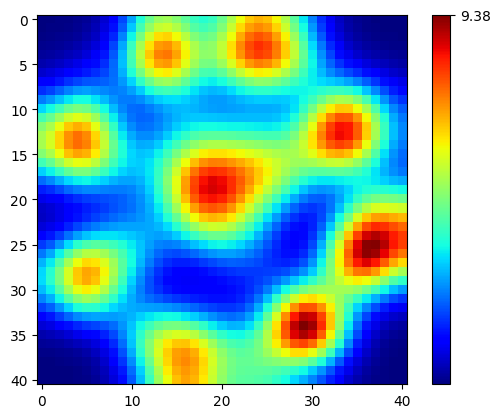

582382 582382


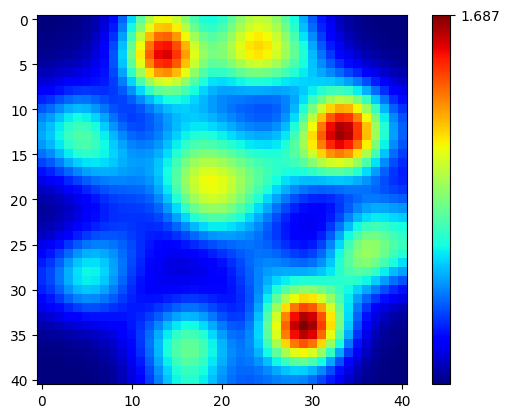

582382 582382


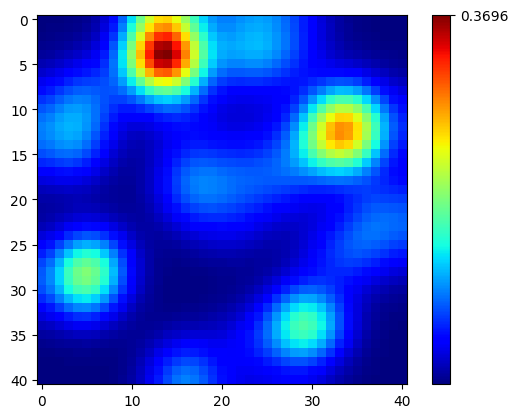

582382 582382


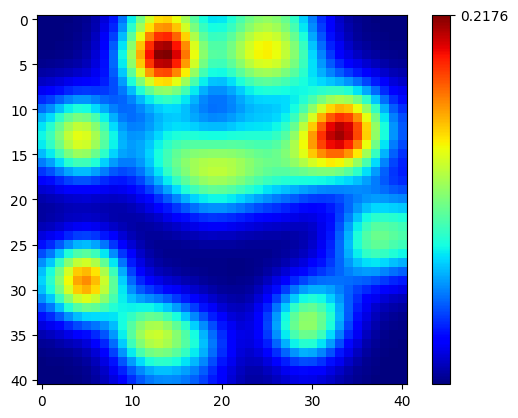

582382 582382


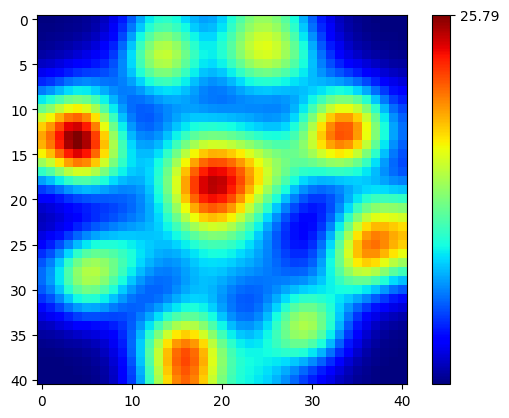

582382 582382


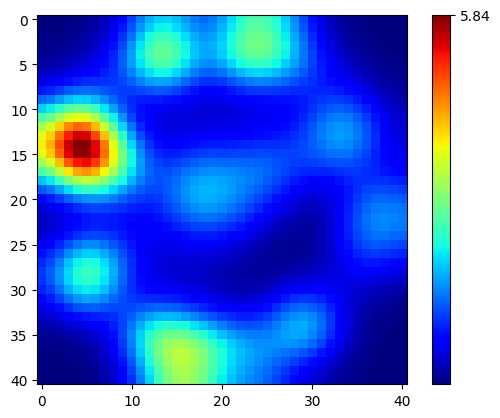

582382 582382


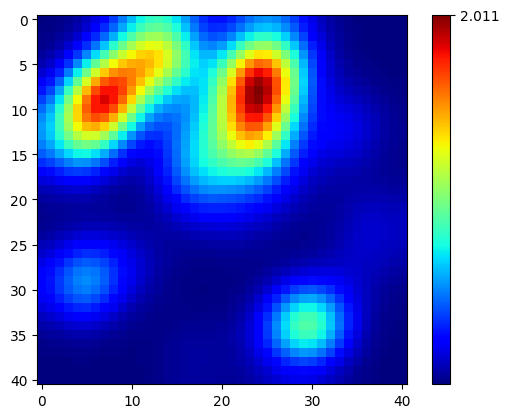

582382 582382


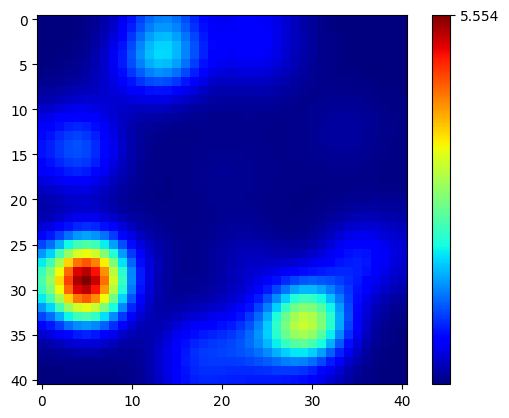

582382 582382


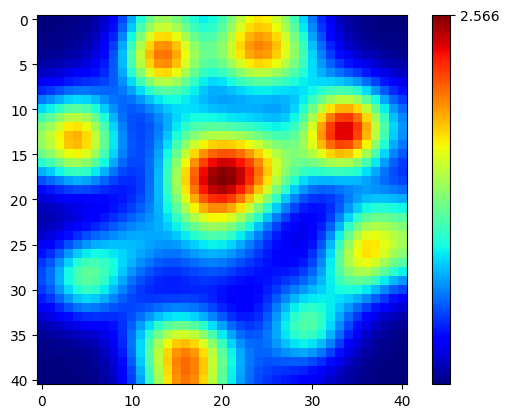

582382 582382


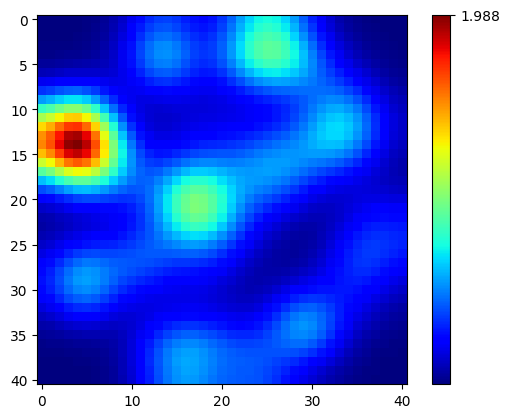

582382 582382


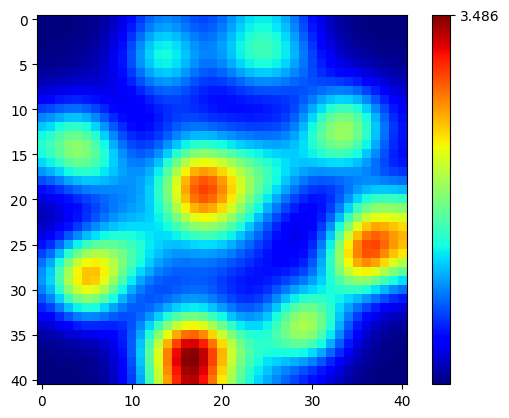

582382 582382


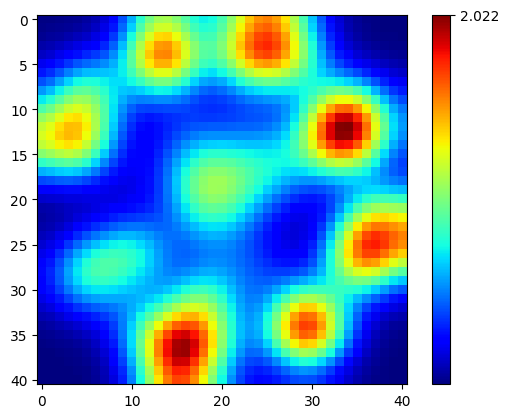

582382 582382


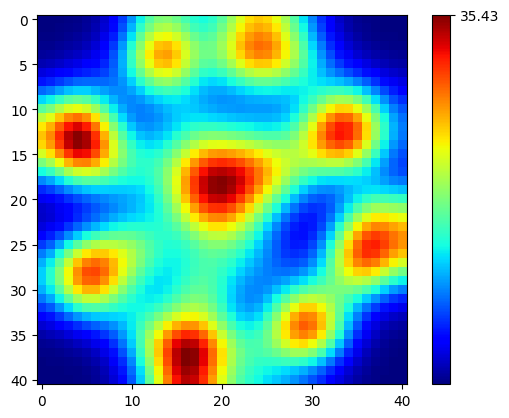

582382 582382


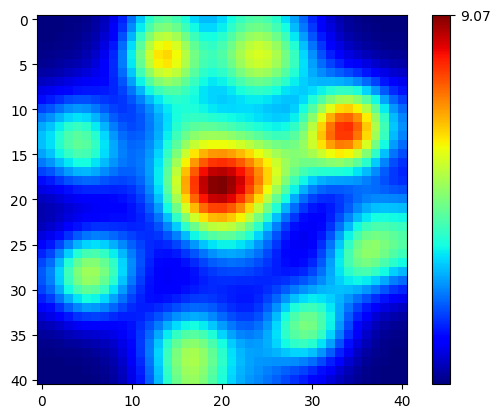

582382 582382


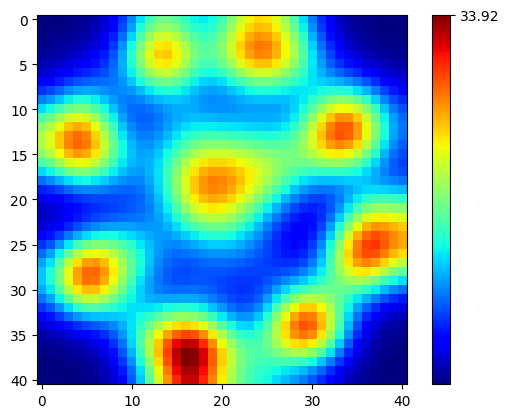

582382 582382


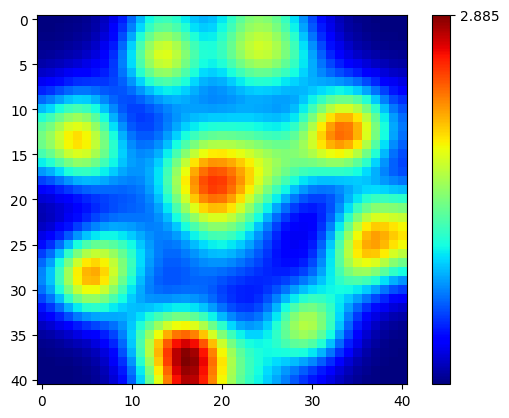

582382 582382


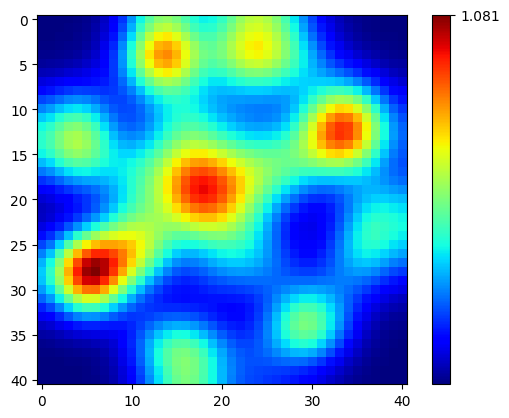

582382 582382


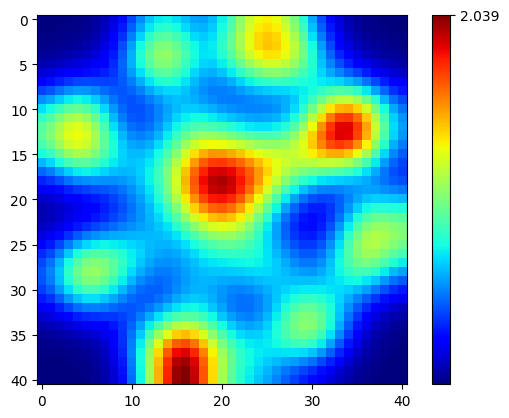

582382 582382


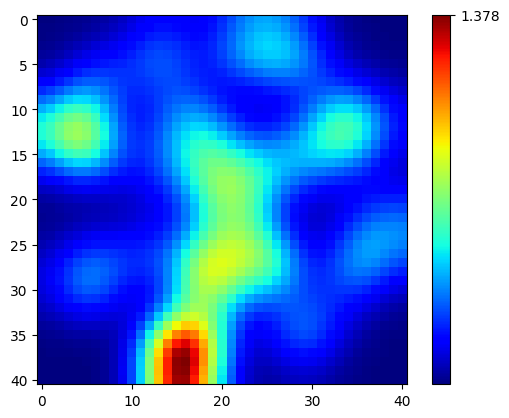

582382 582382


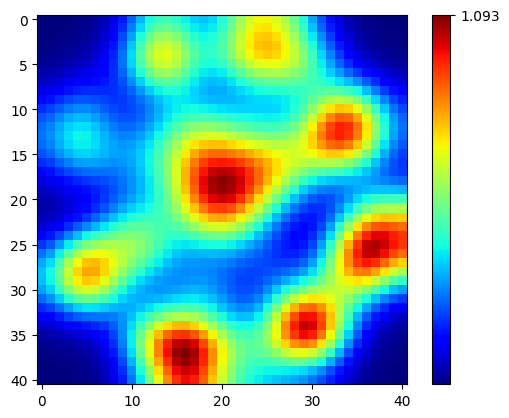

582382 582382


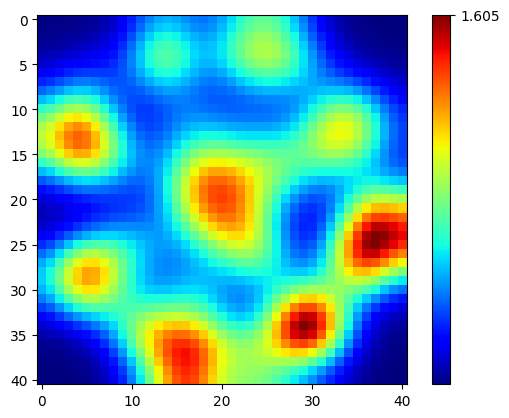

582382 582382


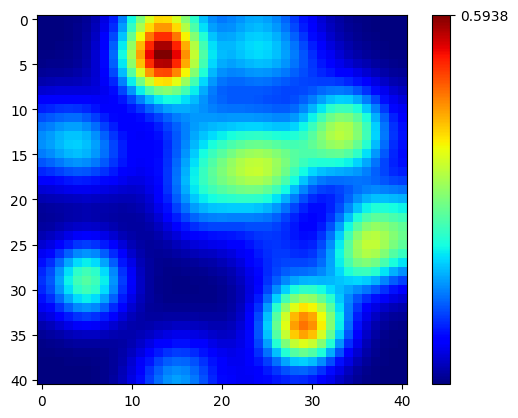

582382 582382


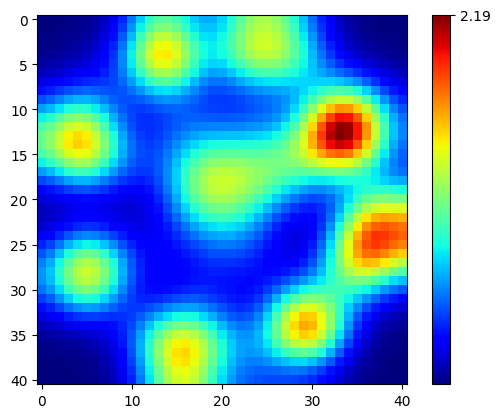

582382 582382


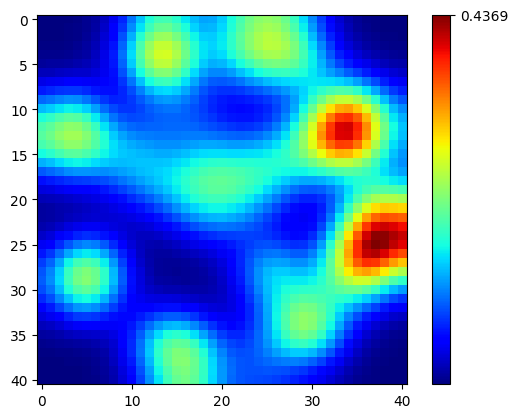

582382 582382


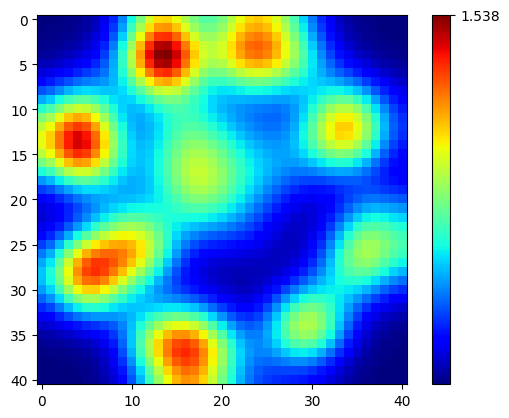

582382 582382


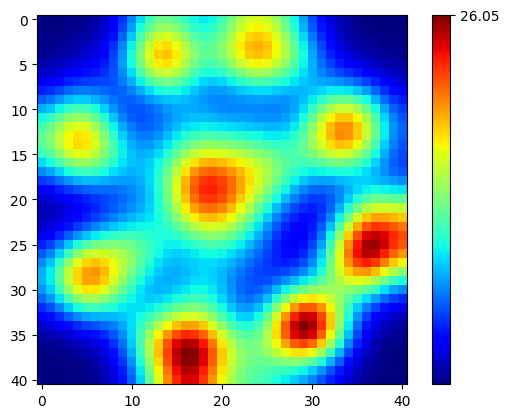

582382 582382


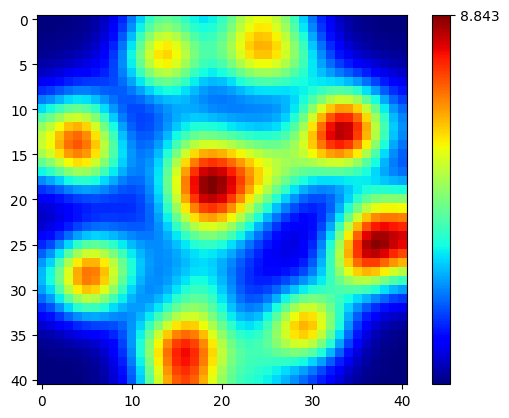

582382 582382


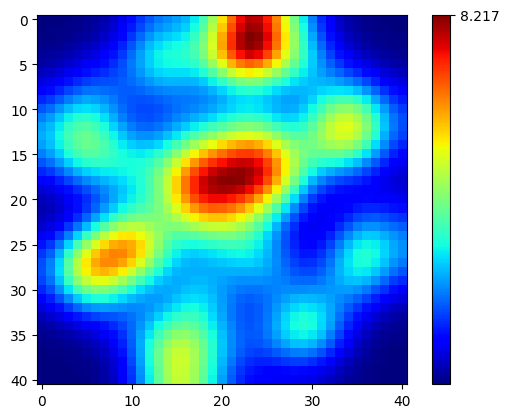

582382 582382


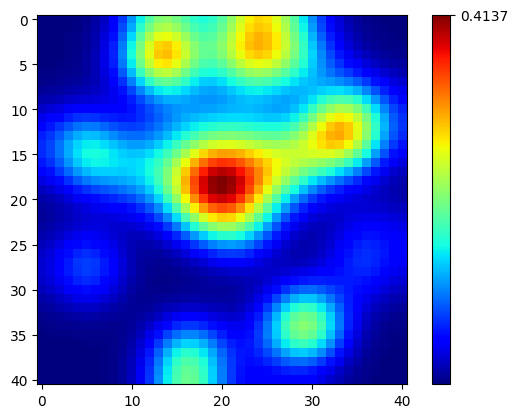

582382 582382


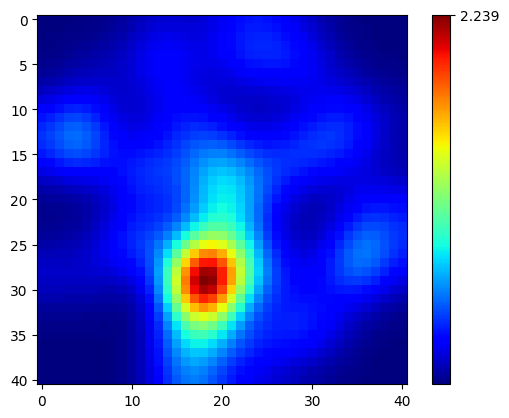

582382 582382


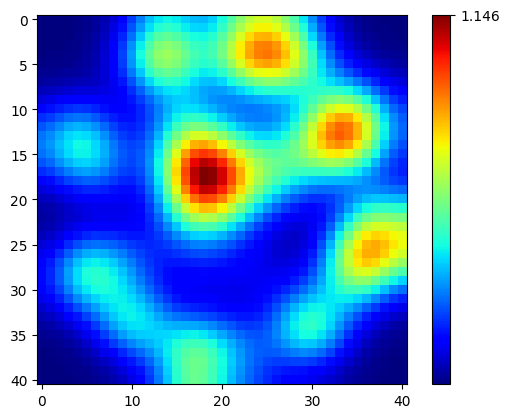

582382 582382


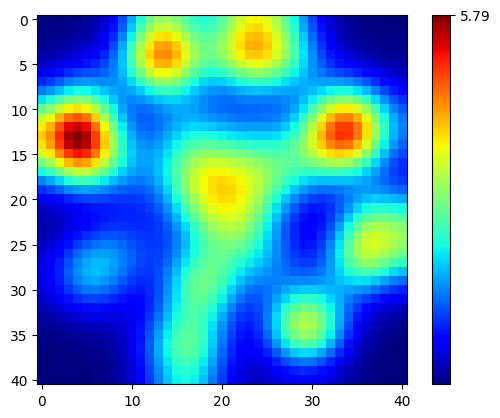

582382 582382


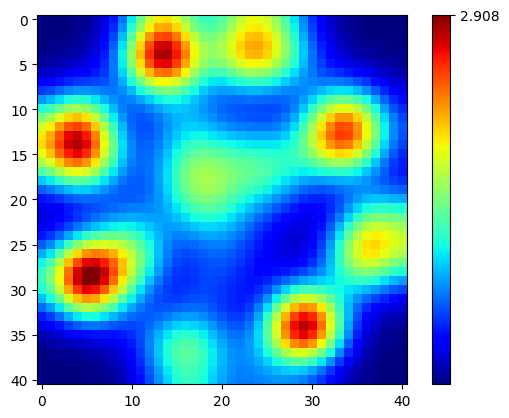

582382 582382


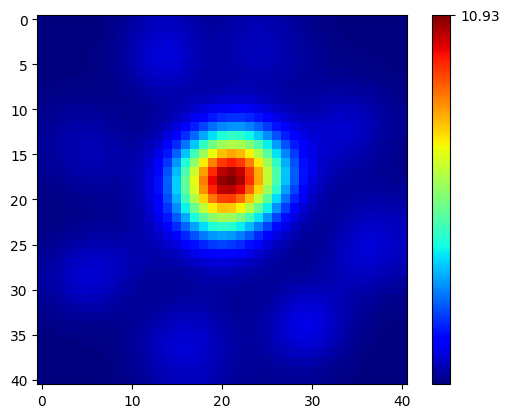

582382 582382


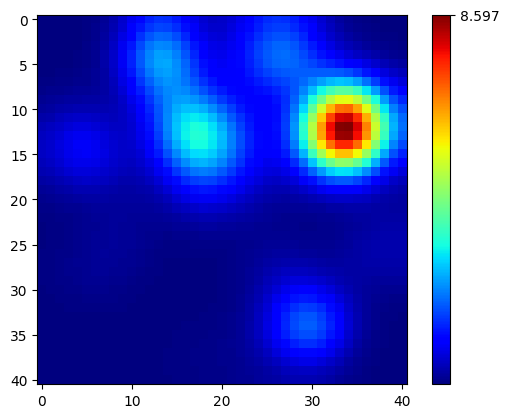

582382 582382


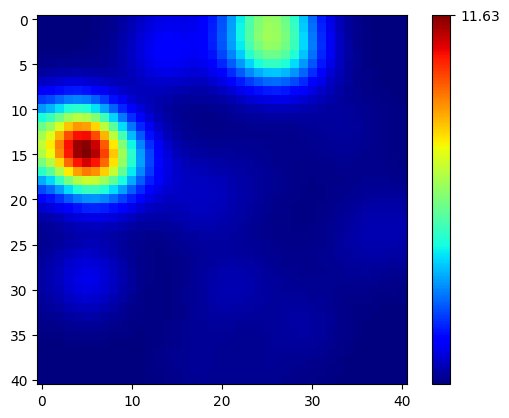

582382 582382


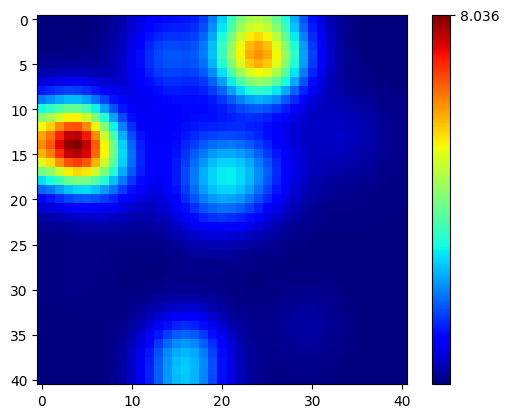

582382 582382


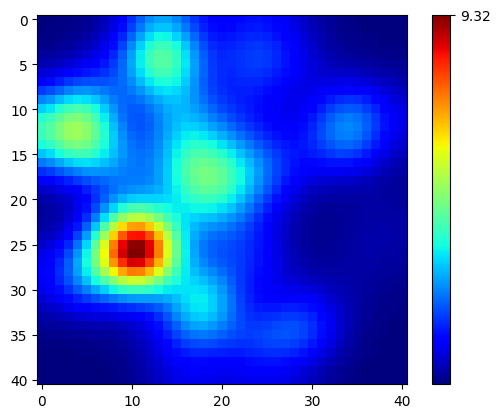

582382 582382


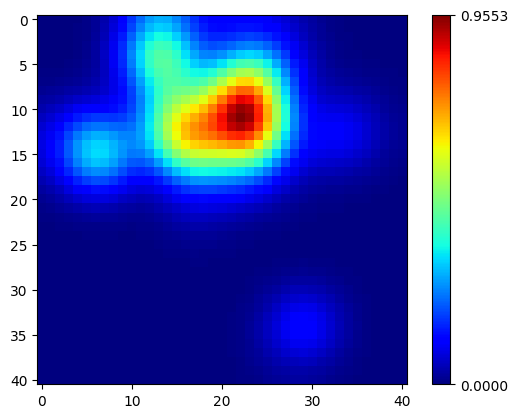

582382 582382


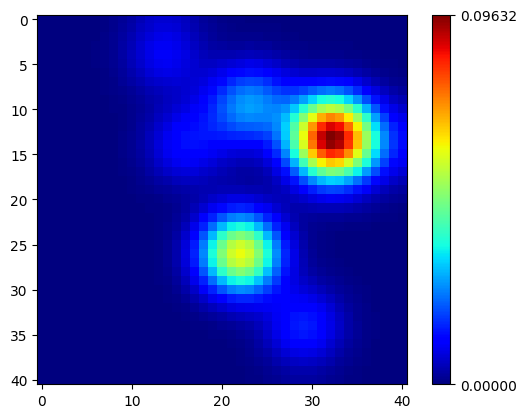

582382 582382


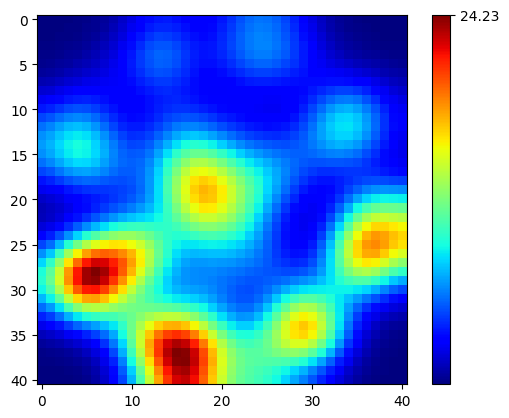

582382 582382


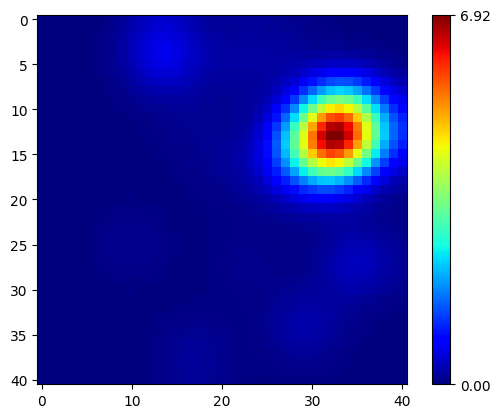

582382 582382


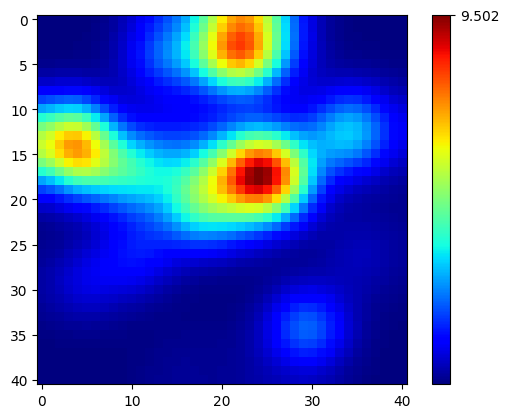

582382 582382


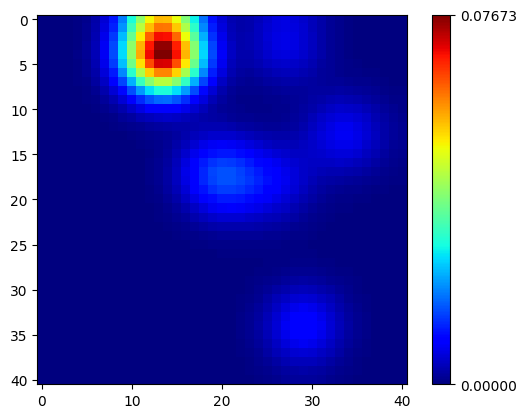

582382 582382


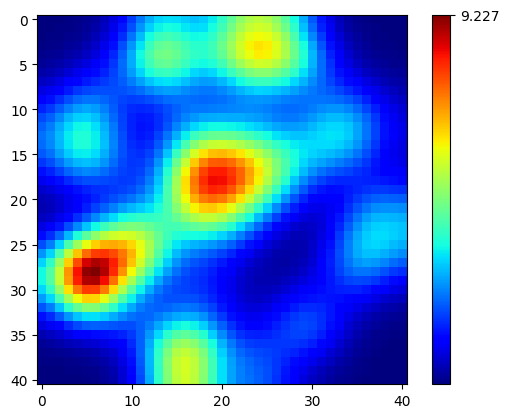

582382 582382


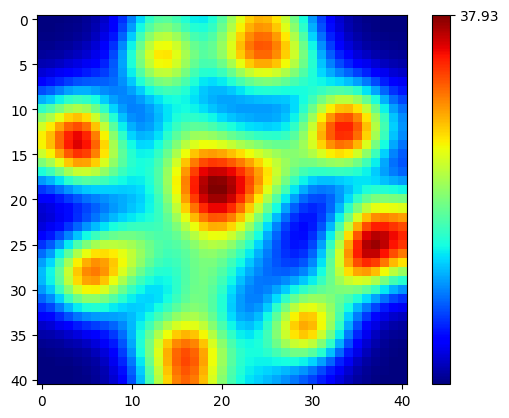

582382 582382


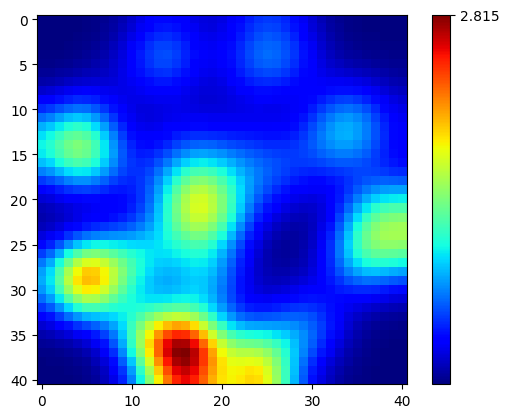

582382 582382


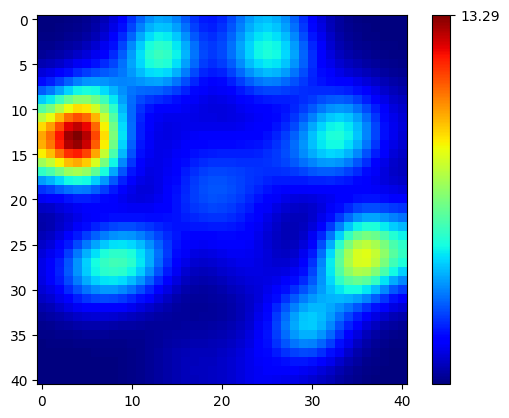

582382 582382


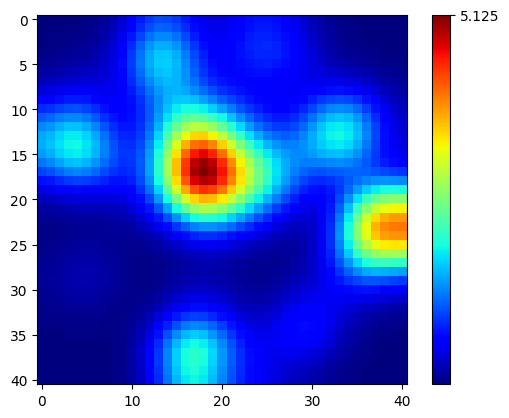

582382 582382


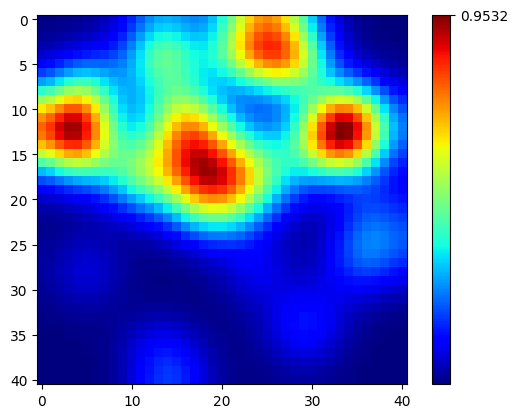

582382 582382


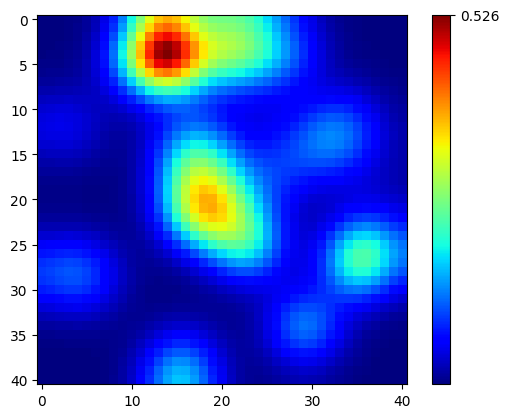

582382 582382


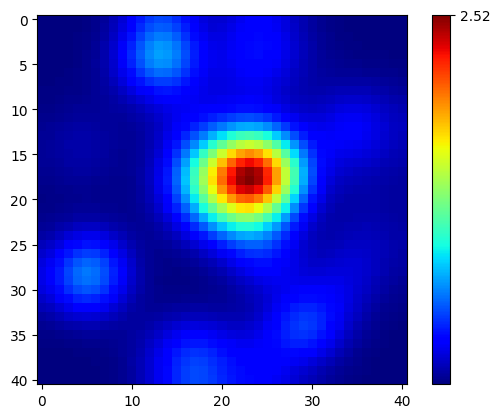

IndexError: index 162 is out of bounds for axis 0 with size 162

In [57]:
for i in range((binned_data).shape[1]):
    print(len(binned_data[i, :]), len(position))
    
    ##### The occupancy adds +bin len for each position ie. it is in the actual time domain to find the time there.
    #so if you give 480 it counts it as 480 ms whereas everywhere else in the code it was using it to index etc.
    # so use 20 ms here as the 480 sample points actually corresponds to the 20ms
   
    binned_data[i, :][low_speed_index] = 0 ## dont want to include spikes that happened when the animal was not moving
    
    
    bin_sizes = [3.2, 4, 5]
#     smoothing = [0, 1, 2, 3, 4, 5]
    
    
    placemap = jcl.analysis.FiringRateMap(
                                            binned_data[i, :],
                                            speed_filtered_positions, 
                                            np.array([160,160]), ### MAYBE INCREASE TO 180
                                            np.array([4,4]), 
                                            20
#                                             ,smooth_sd=3
    )
    jcl.visualization.plot_map(placemap)
    

In [10]:
def compute_bins(position_range, bin_len=480):
    """ Compute bin edges for given spike times.

        Args:
            position_range - tuple or list with first position timestamp and last position time stamp
            bin_len - length of a bin in ms (default 1s/50 = 20ms which is 480 samples of spikes)
            sampling_period - sampling period in ms (default 1s/20kHz = 0.05ms)
        Return:
            List of bin edges (in ms), total number of bins
    """
    
    bin_num = np.ceil( (position_range[-1] - position_range[0]) / bin_len).astype(int)
    bin_edges = np.arange(position_range[0], position_range[-1]+480, bin_len)
    
    return bin_edges, bin_num

def bins_from_spike_times(spike_times, position_range, bin_len=480, dtype=np.uint16, dense_loading=True, return_mat_type=np.array):
    """ Bin given spike times, each bin contains total number of spikes.

        Args:
            spike_times - list of spike times per neuron (list of iterables, pre-sorted in a non-descending order)
            position_range - tuple or list with first position timestamp and last position time stamp
            bin_len - length of a bin in ms (default 1s/50 = 20ms)
            sampling_period - sampling period in ms (default 1s/24kHz)  1/480
            dtype - dtype to use for bins, default np.uint16 (np.uint8 would use less memory, but can store only up to 256 spikes per bin)
            dense_loading - if True (default) load data into a dense np.ndarray then convert to a `return_mat_type` (fast), if False load into a sparse matrix (slow, but memory efficient)
            return_mat_type - type of matrix to be returned (default is sparse `csc_matrix` for efficient storage and relatively fast column slicing)
        Return:
            Matrix with spike count per bin ((neuron num, time bins), `return_mat_type`)
    """
    # leave this two lines here in case we find non-sorted spikes (.res files)
    # maxes = [np.max(st) if len(st) > 0 else 0 for st in spike_times]
    # last_spike_time = to_ms(np.max(maxes), sampling_period)  # in ms
    bin_edges, bin_num = compute_bins(position_range, bin_len)

    if dense_loading:
        # fastest loading (due to indexing), but requires a lot of memory
        binned_data = np.empty((len(spike_times), bin_num), dtype=np.uint16)
    else:
        # lil_matrix is fast for loading rows, convert later to return_mat_type
        binned_data = lil_matrix((len(spike_times), bin_num), dtype=np.uint16)
    print((bin_edges.shape), binned_data.shape)
    for n, st in enumerate(spike_times):
#         st_ms = to_ms(np.array(st), sampling_period)
        hist = np.histogram(st, bins=bin_edges)[0]
        binned_data[n] = hist

    return return_mat_type(binned_data), bin_edges, bin_num